# Advanced Housing Dataset Analysis

# To Do

1. Table of contents
2. Finish doing one-hot plus my ordinal encoding
3. Figure out how to use unprocessed categorical features with LightGBM (it says it can do it, but I haven't been able to figure out how. Maybe I have to convert from a pandas dataframe to whatever datastructure LGB prefers?)
4. Dimensionality reductions / PCA
5. Scale y data, then reverse scale after modeling

# Introduction


Hello. My name is Evan Freeman. Let's analyze a housing dataset and create a model to predict housing prices of new houses that are put on the market.

Here we'll be considering the Ames Housing dataset, which is like the famous Boston Housing dataset, but better!

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Principal Component Analysis???
  2. Univariate
  3. Lasso (L1)
  4. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

*This is a lie currently, will update someday...

# Setup

In [167]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.filterwarnings('ignore')

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56


filepath = 'D:/code/Data/house-prices-advanced-regression-techniques/'
sub_filepath = 'D:/code/Data/advanced_housing_submissions/'

housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

# Also, we're going to need the test ids for submission, so let's grab those

test_id = test['Id']

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [168]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

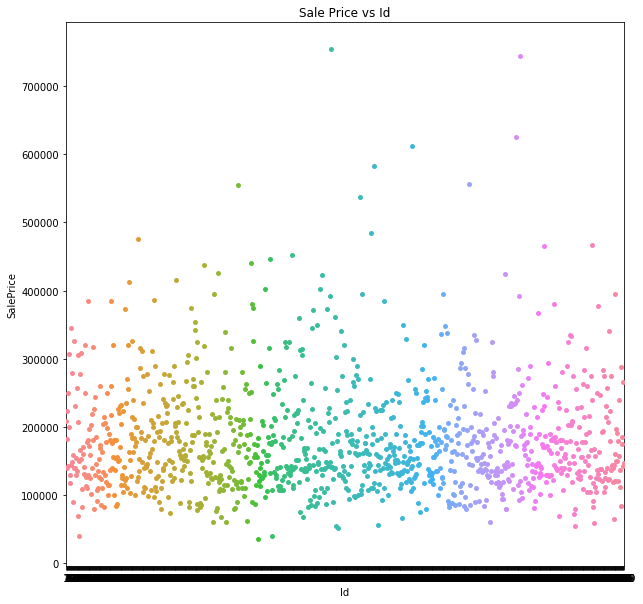

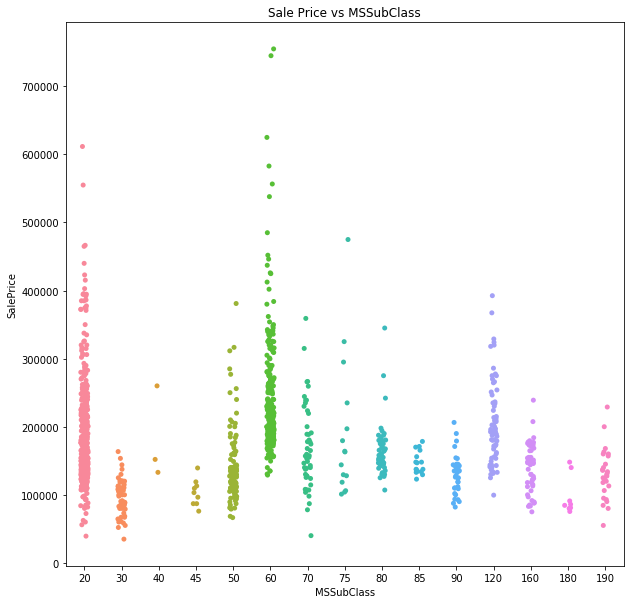

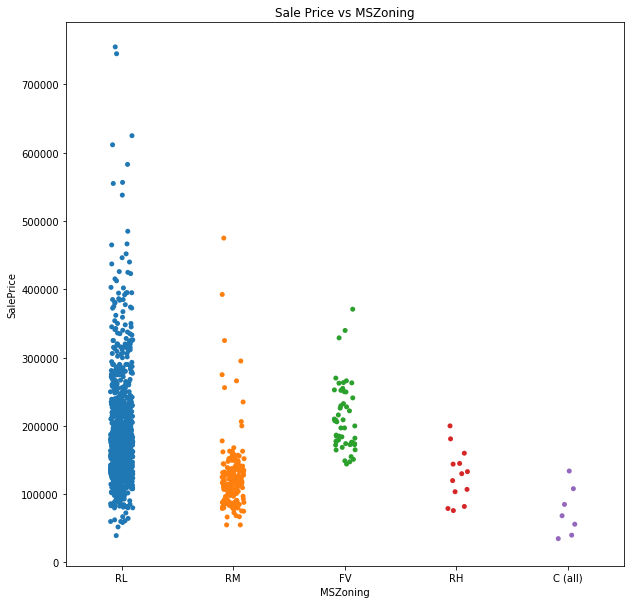

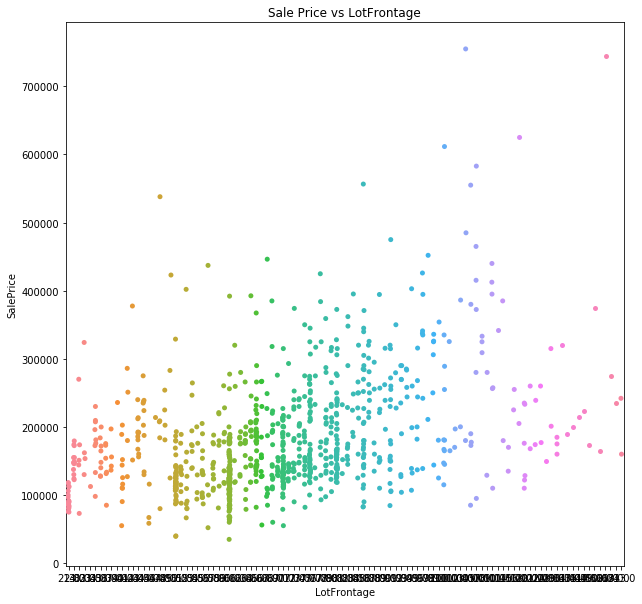

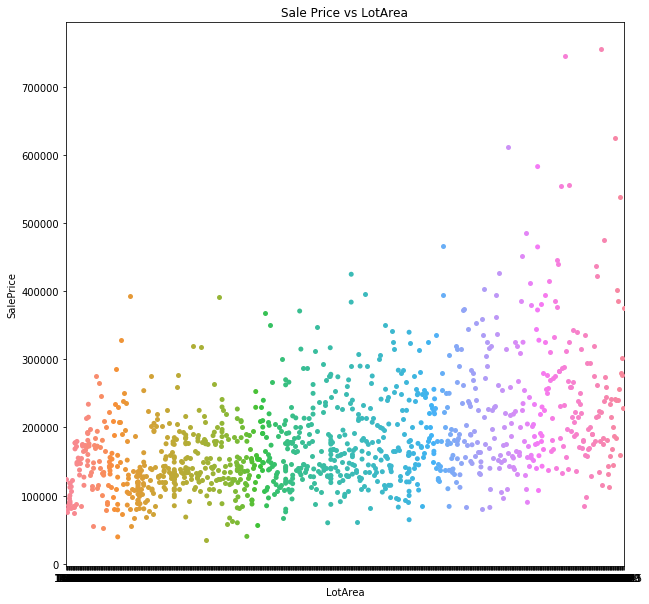

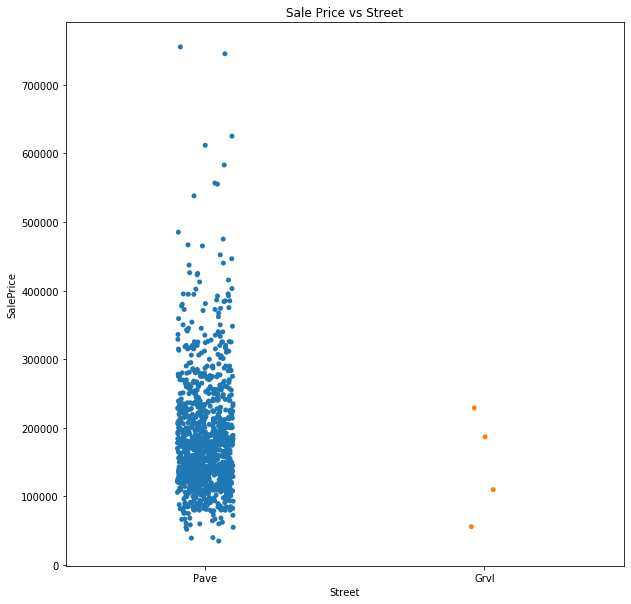

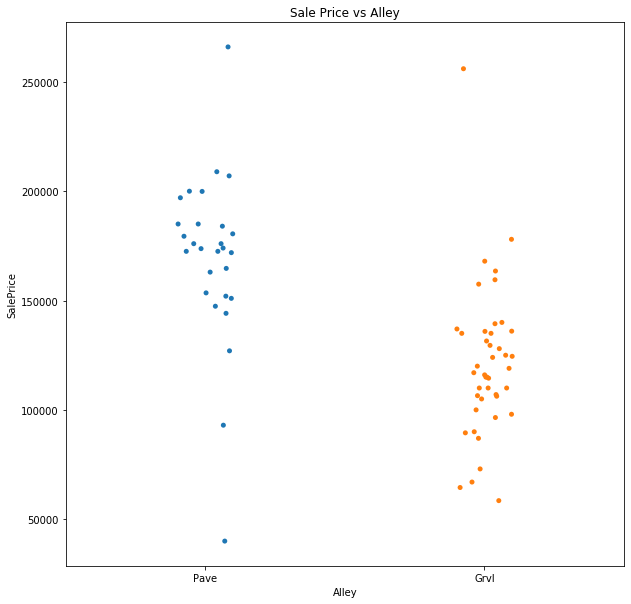

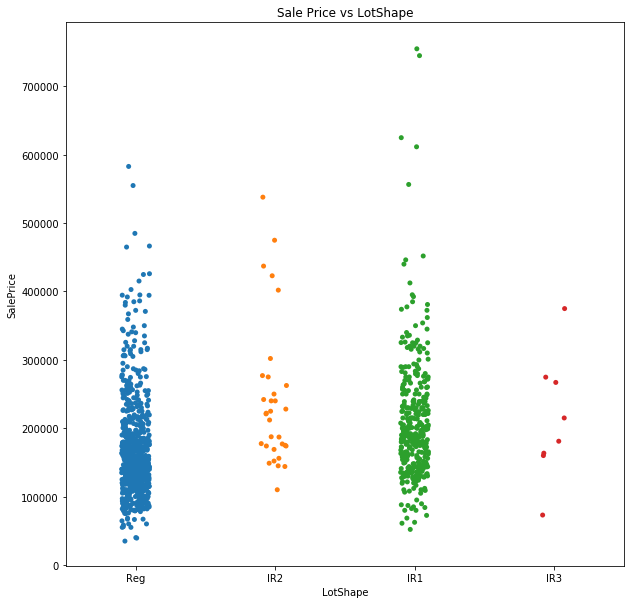

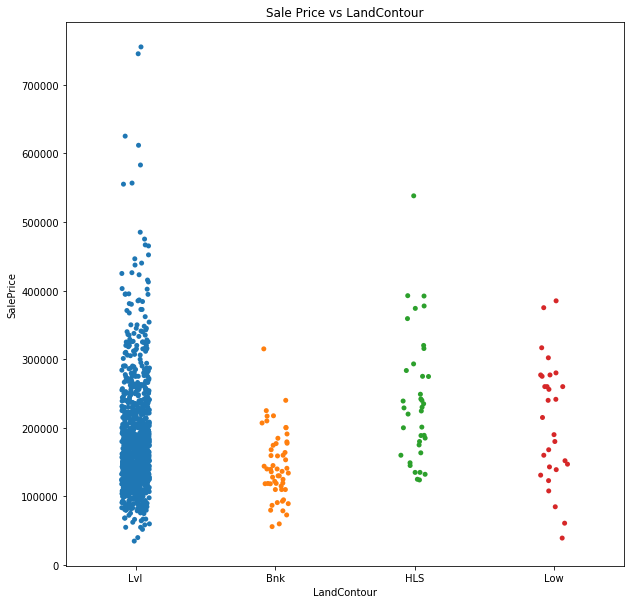

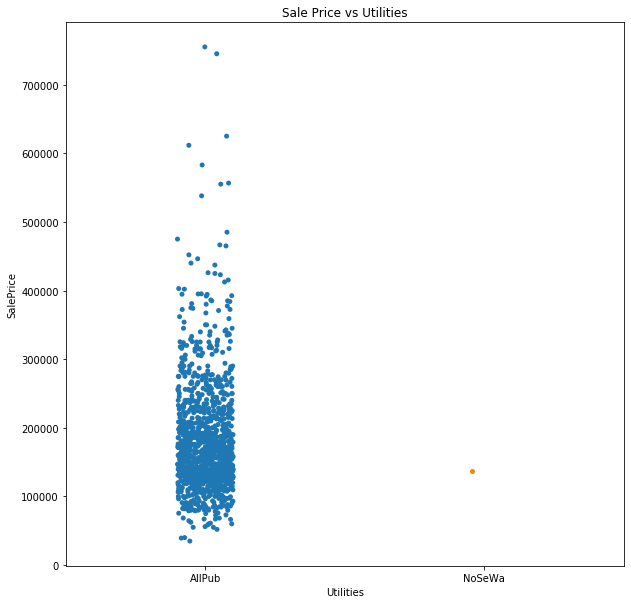

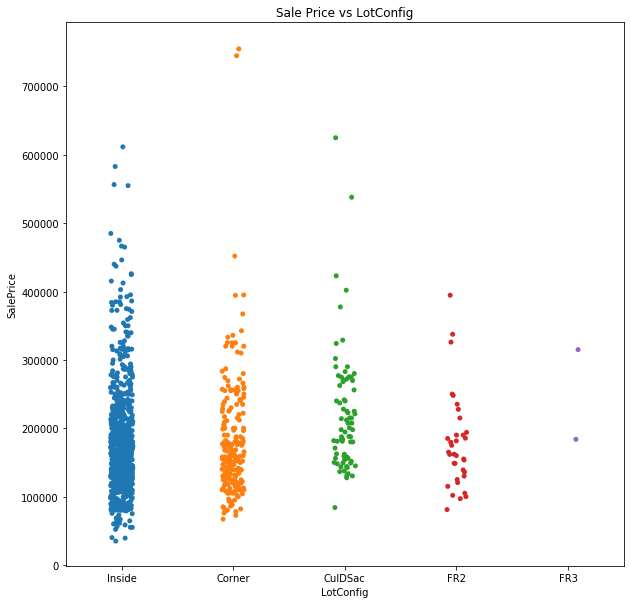

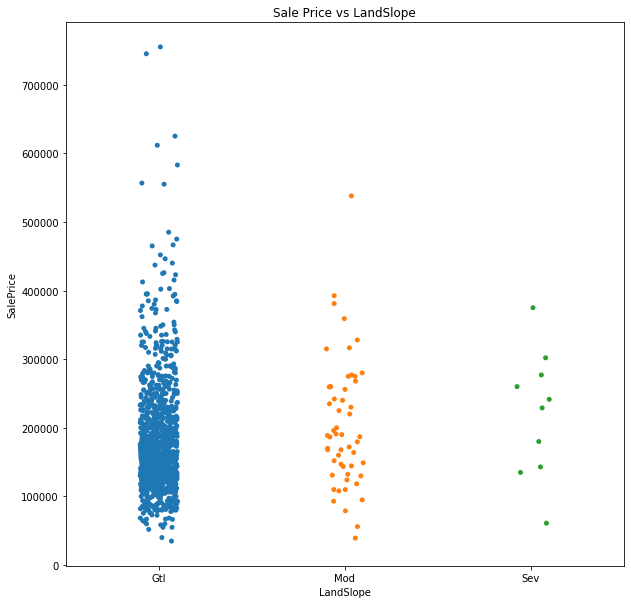

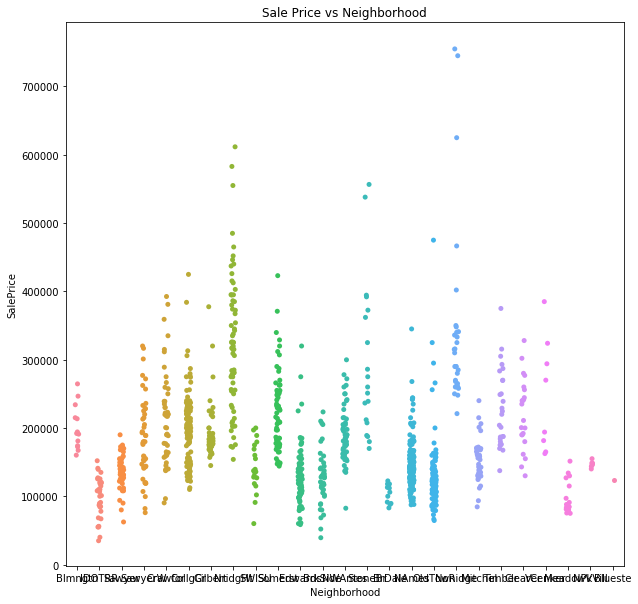

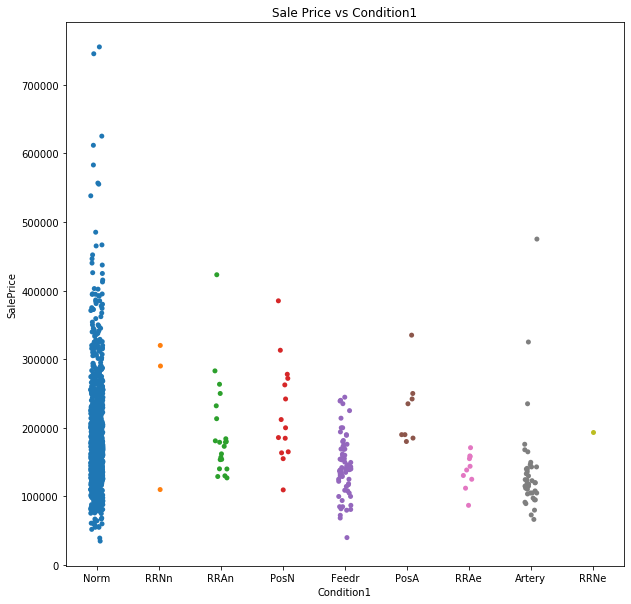

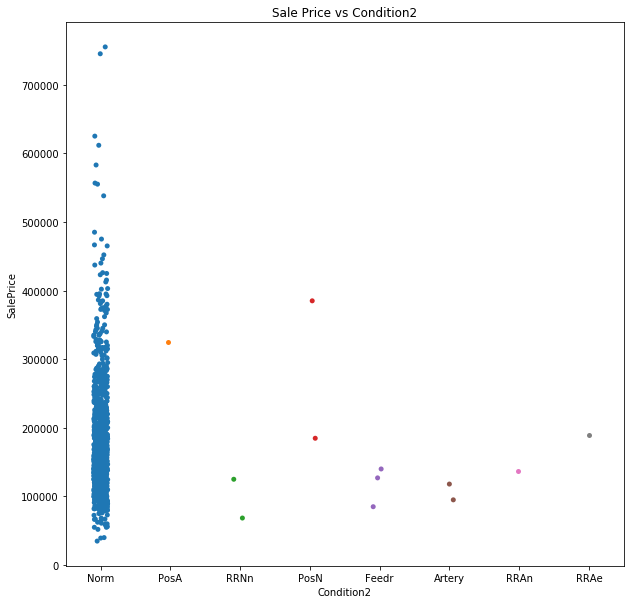

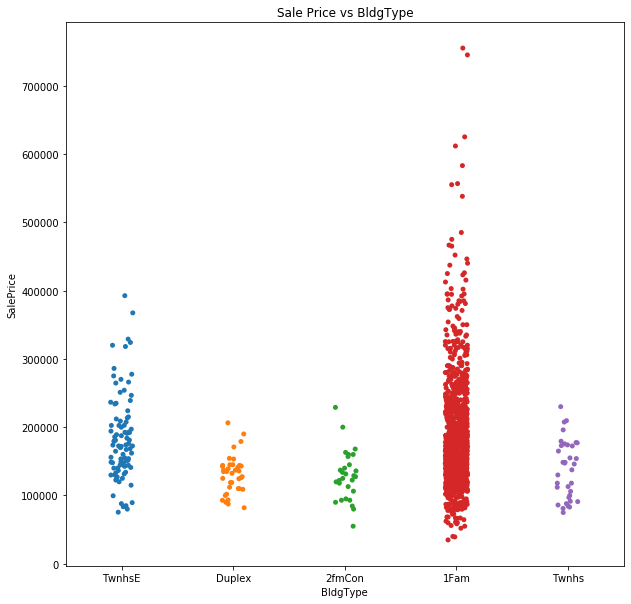

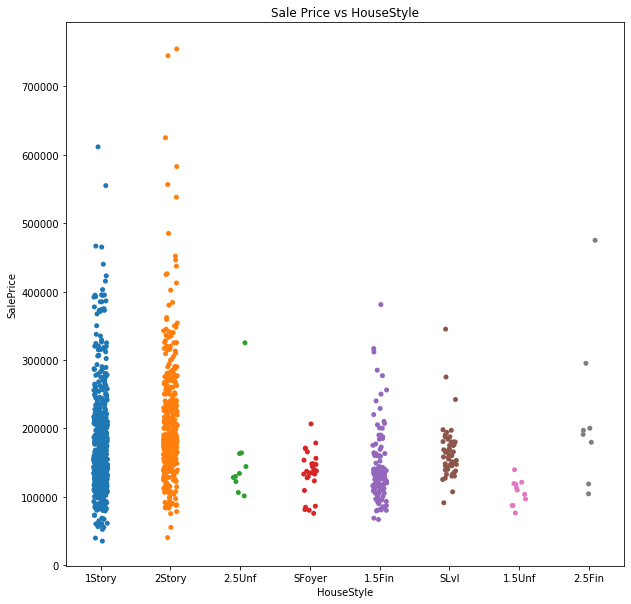

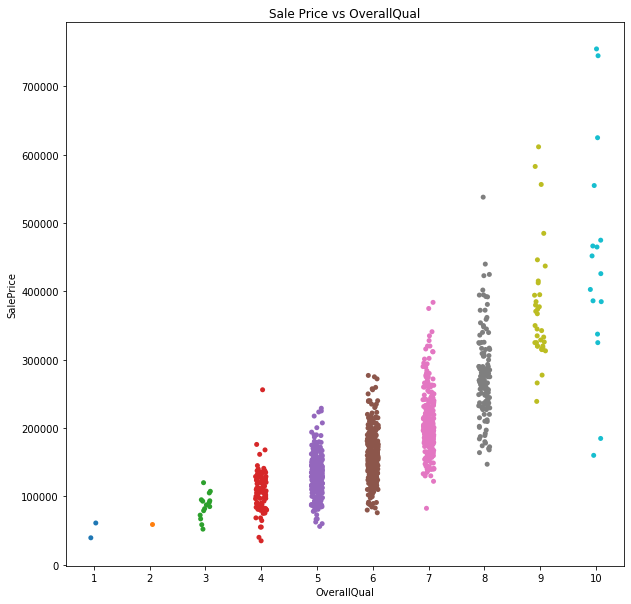

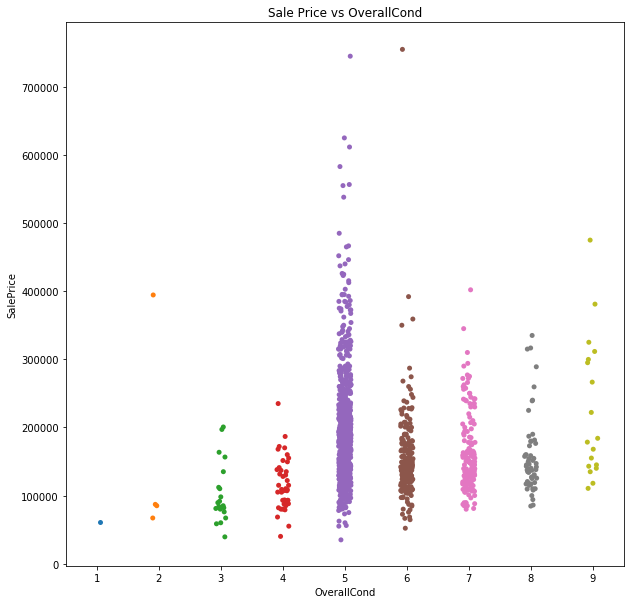

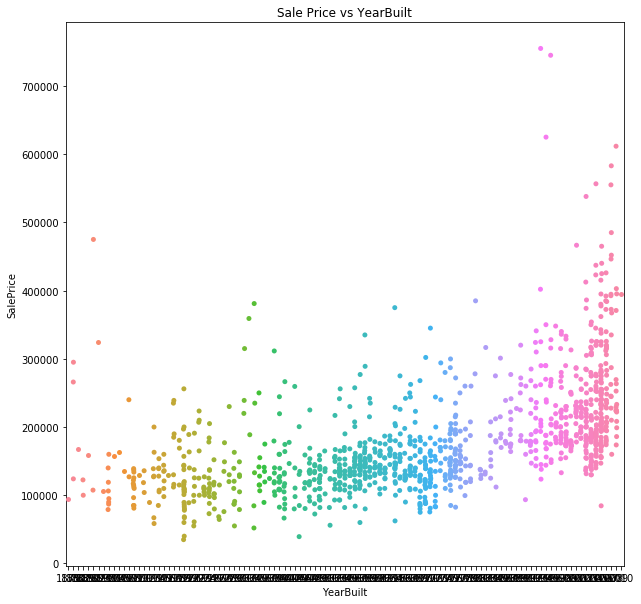

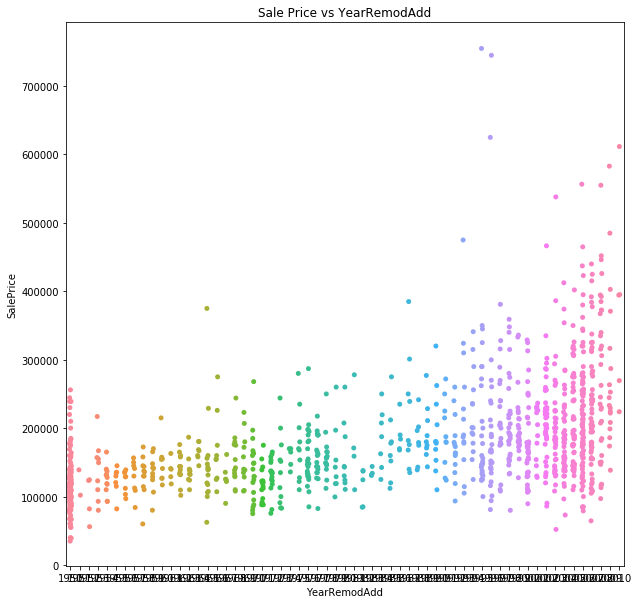

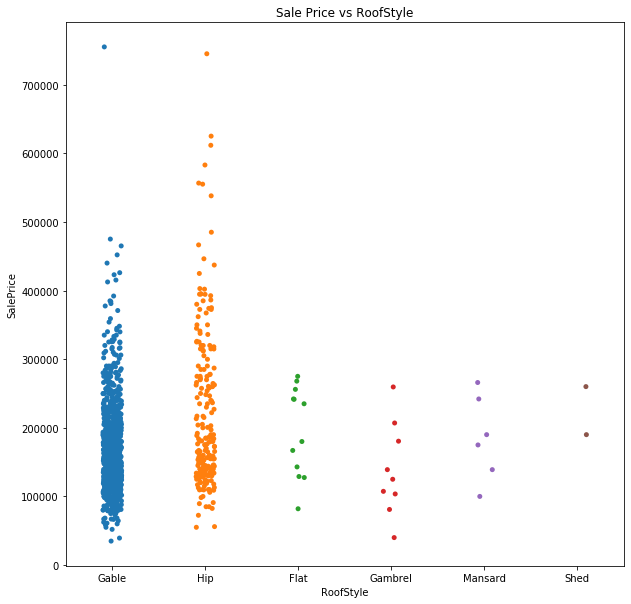

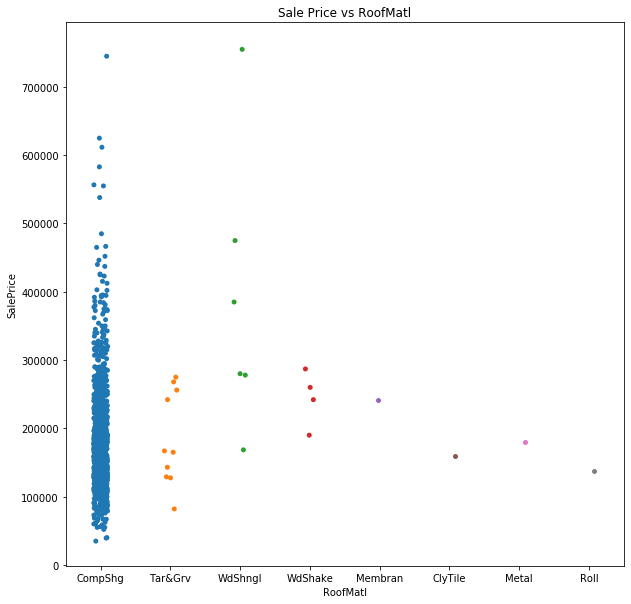

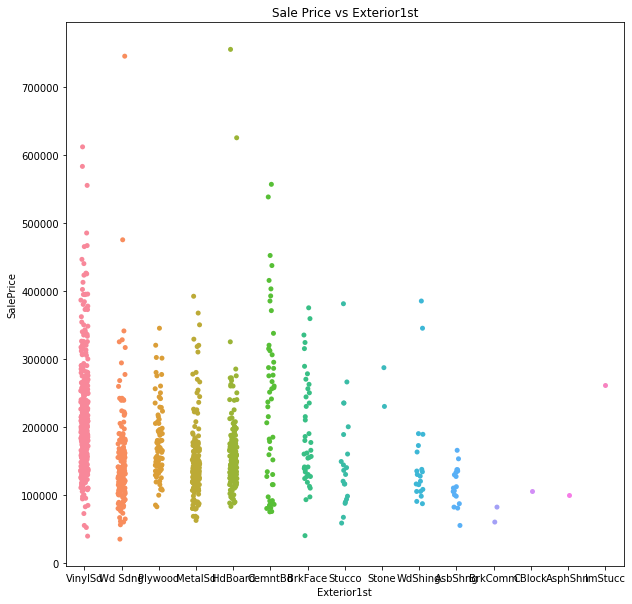

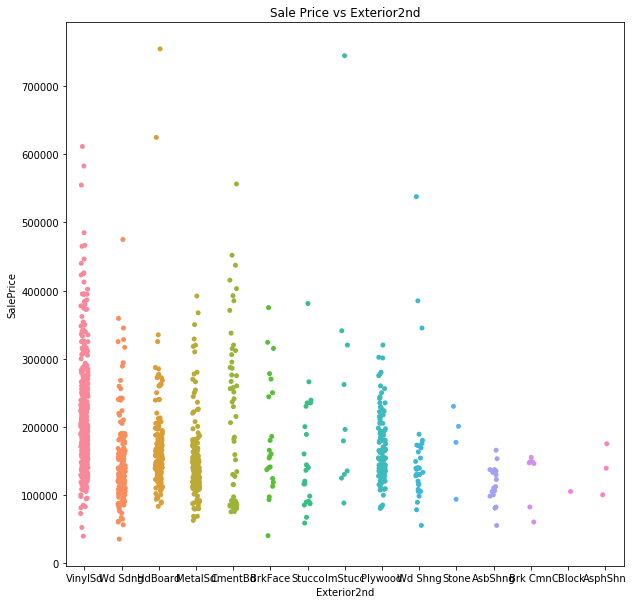

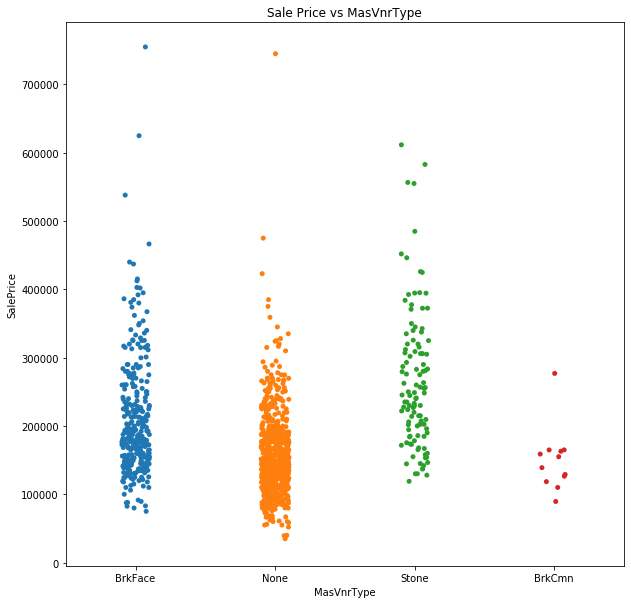

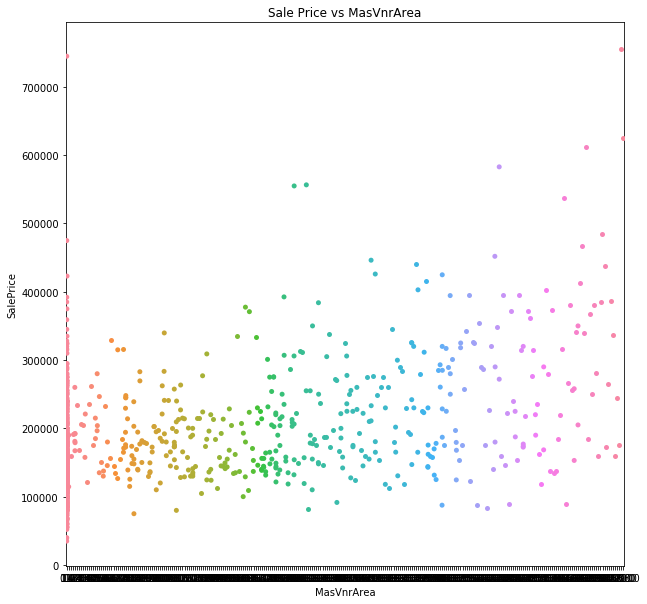

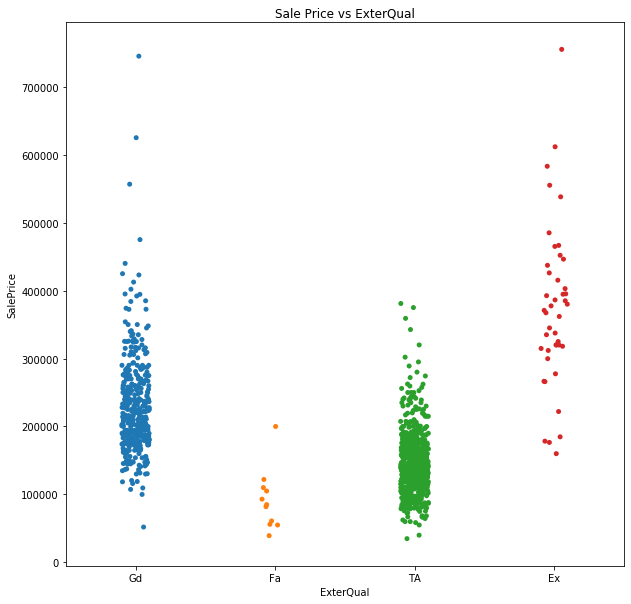

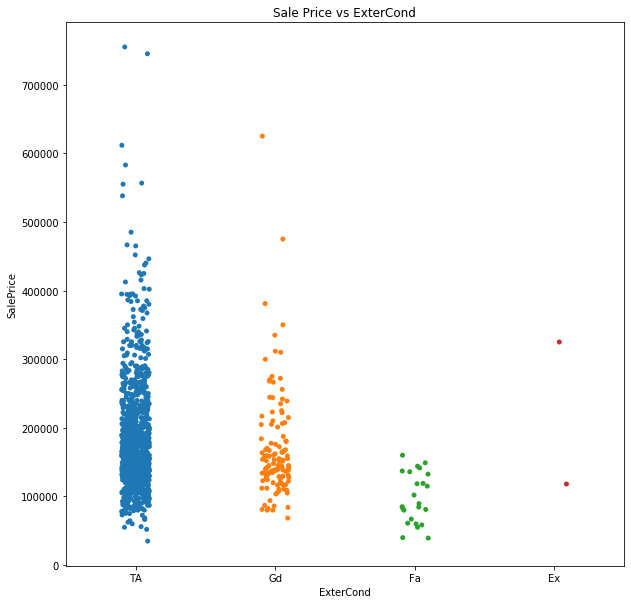

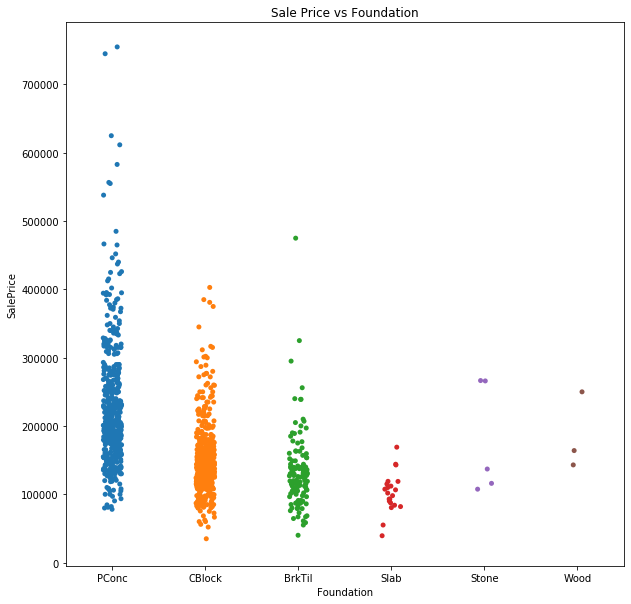

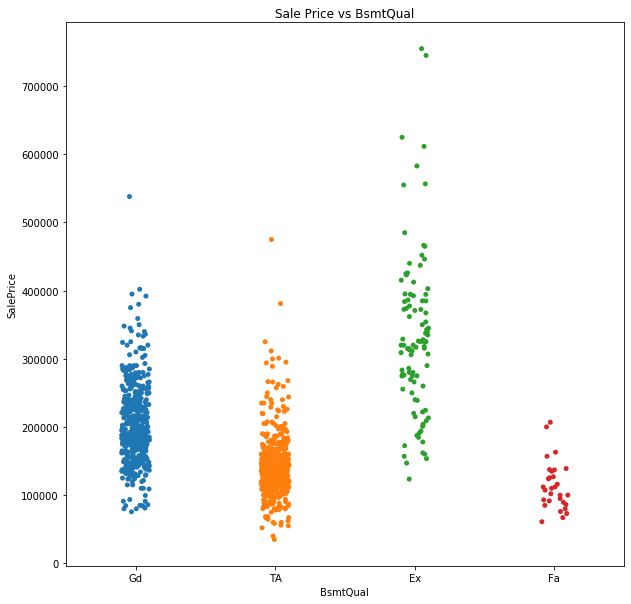

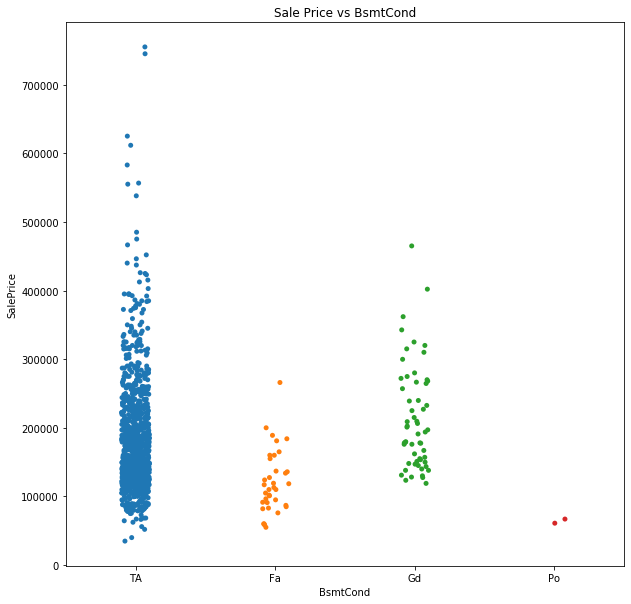

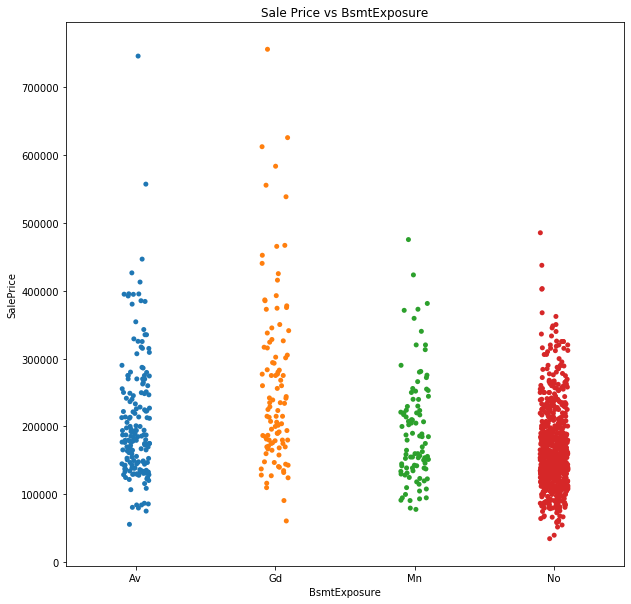

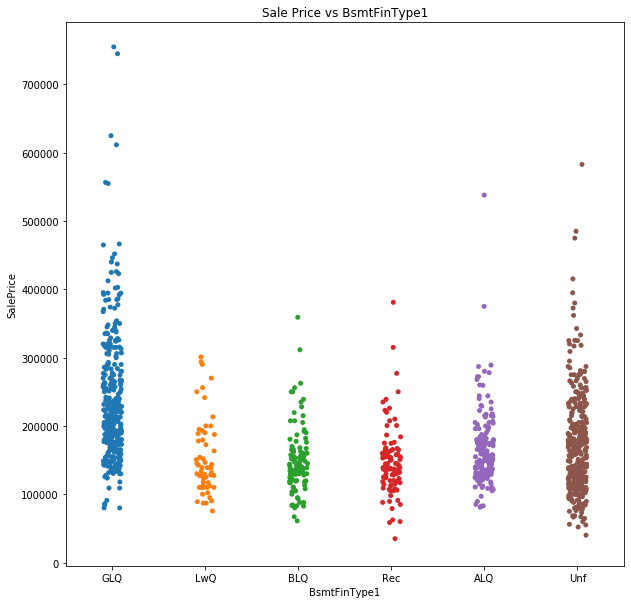

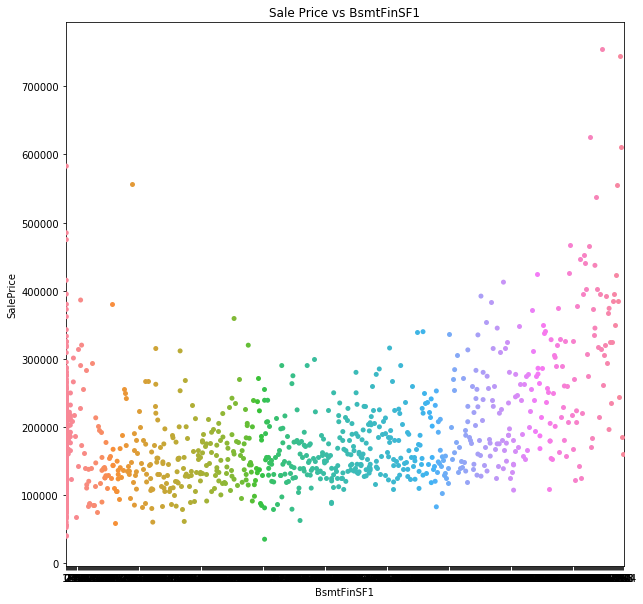

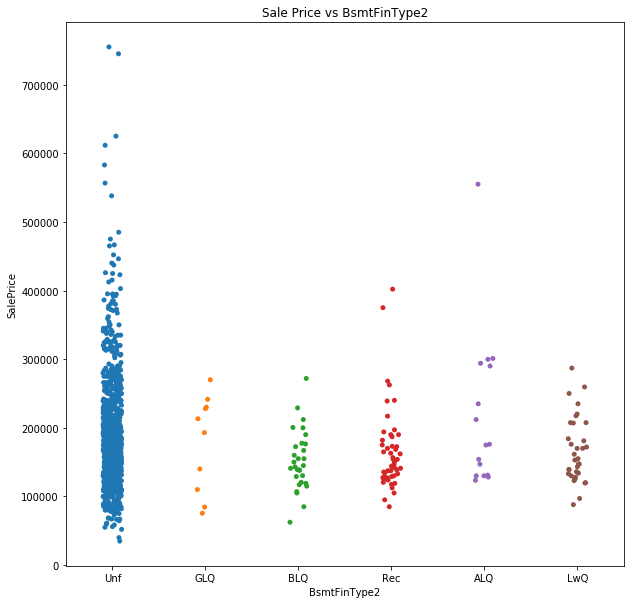

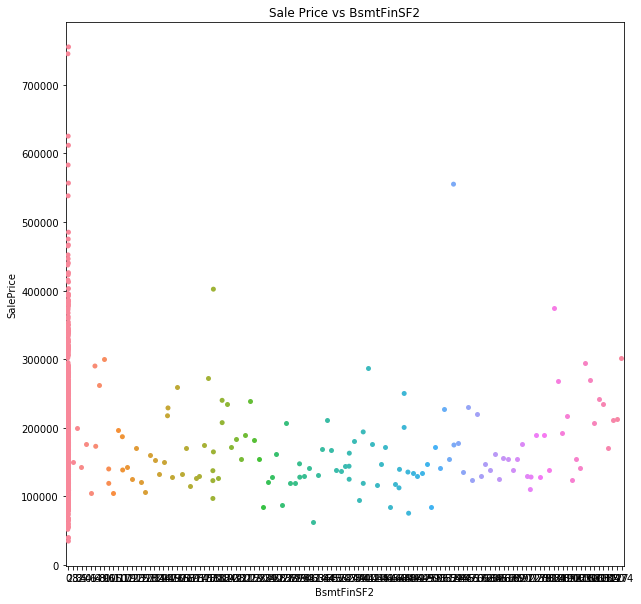

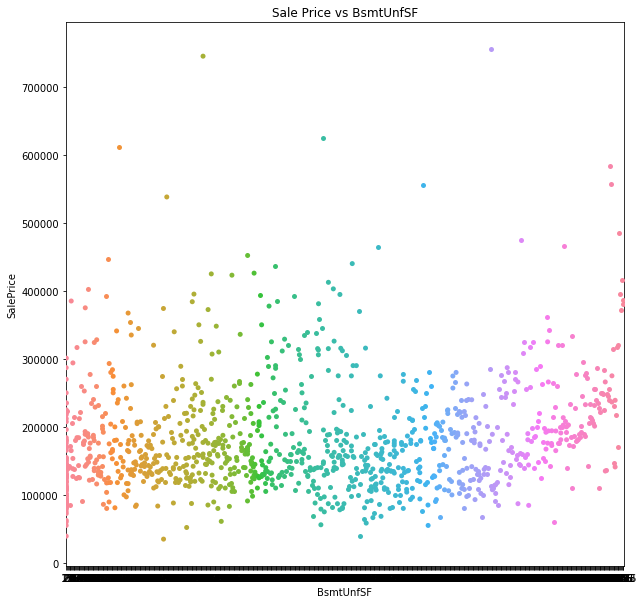

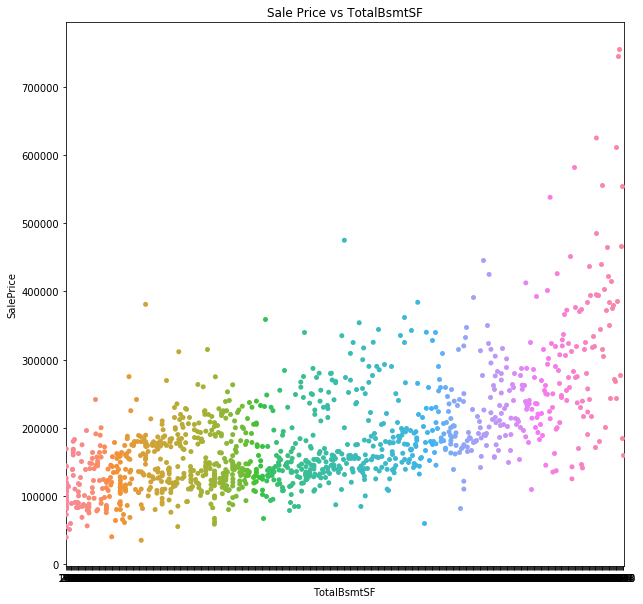

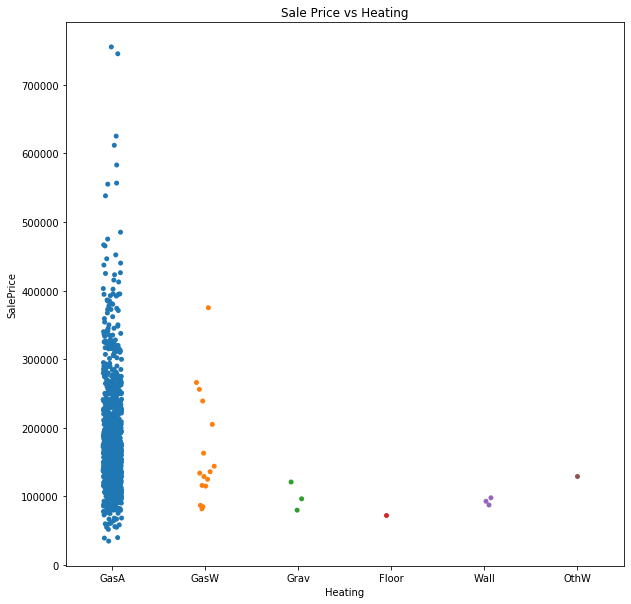

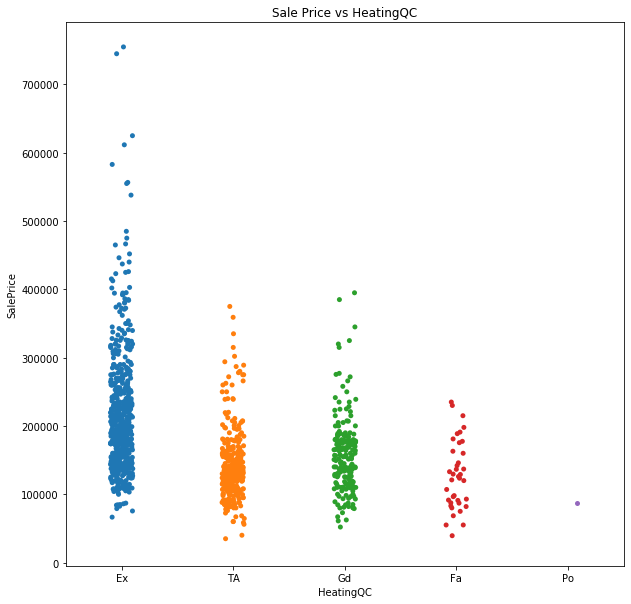

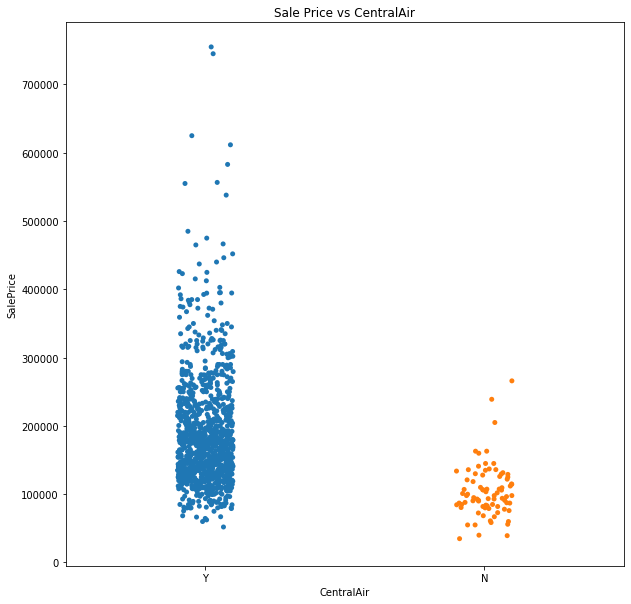

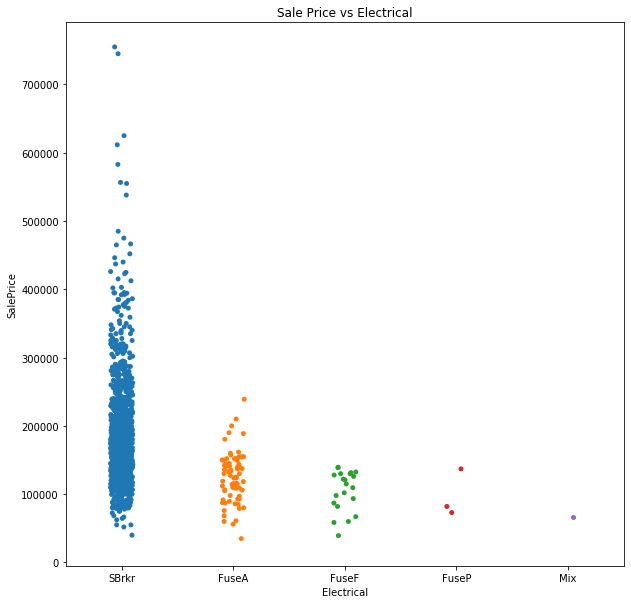

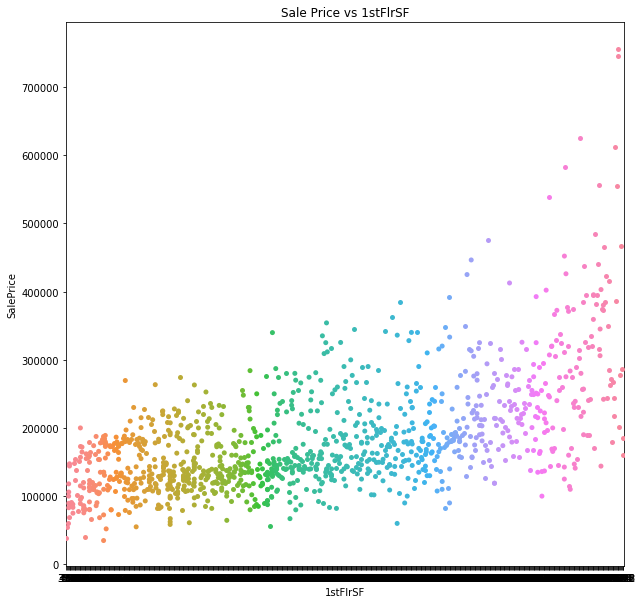

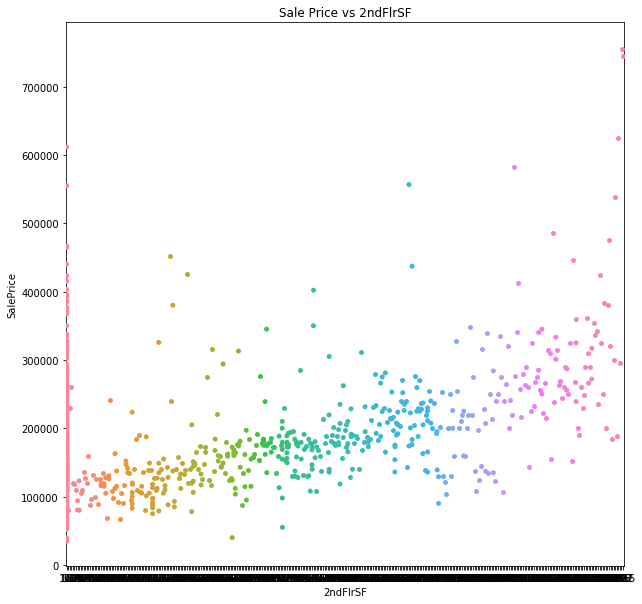

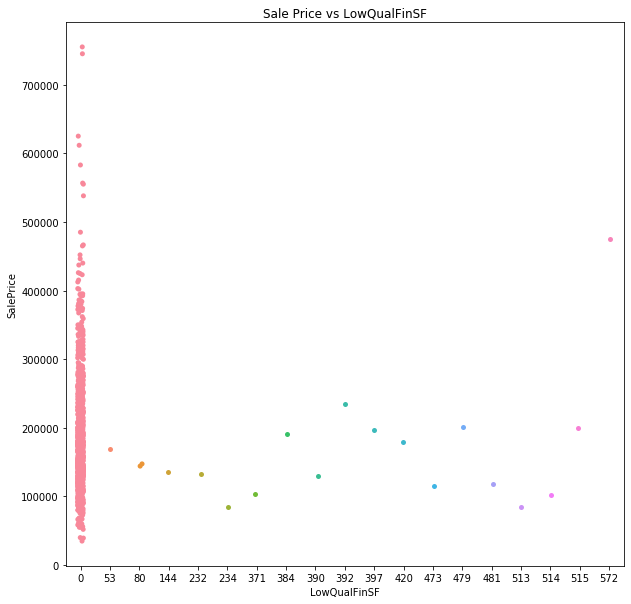

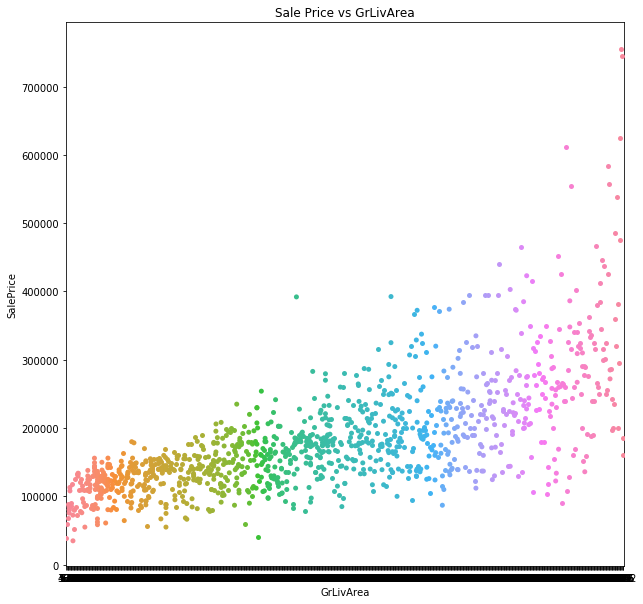

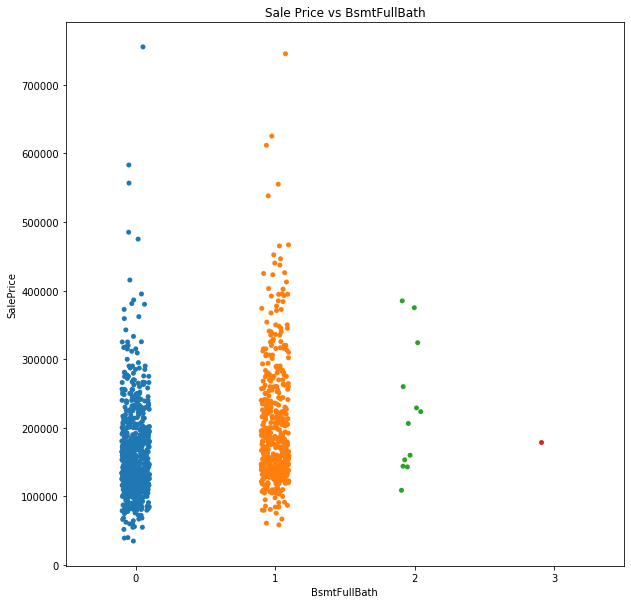

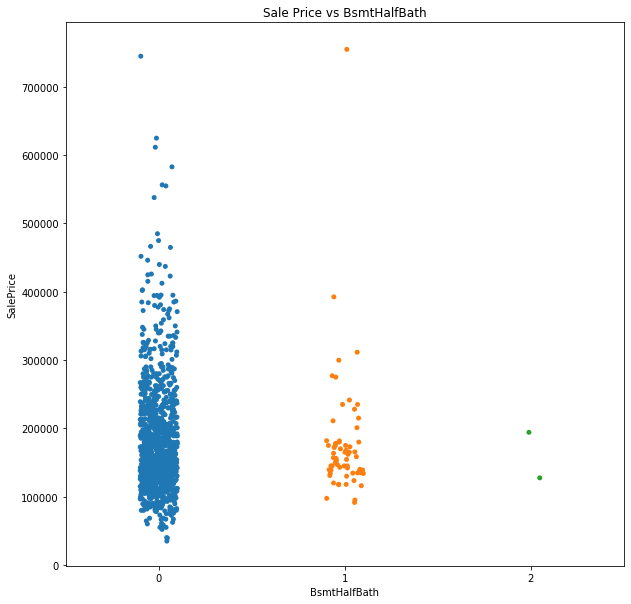

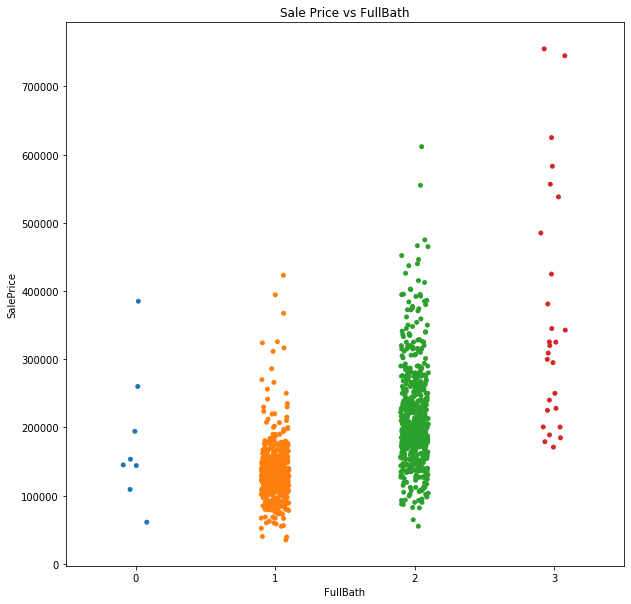

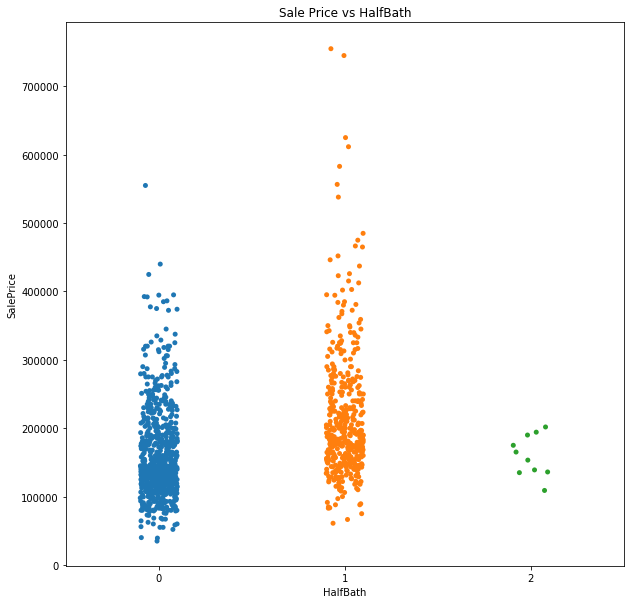

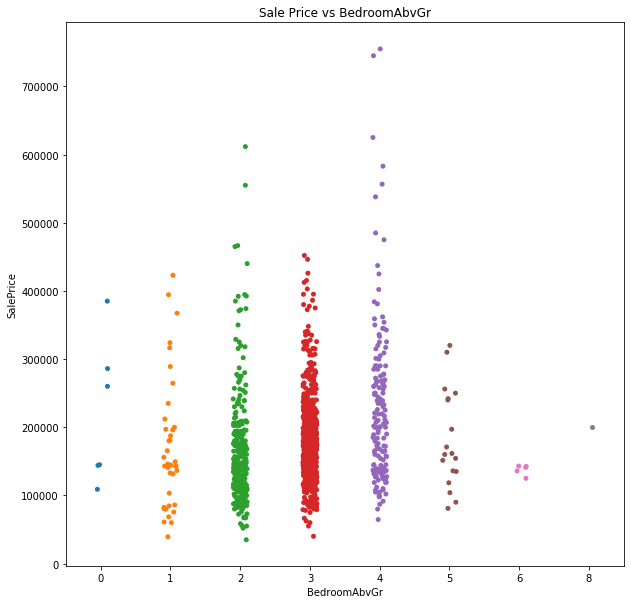

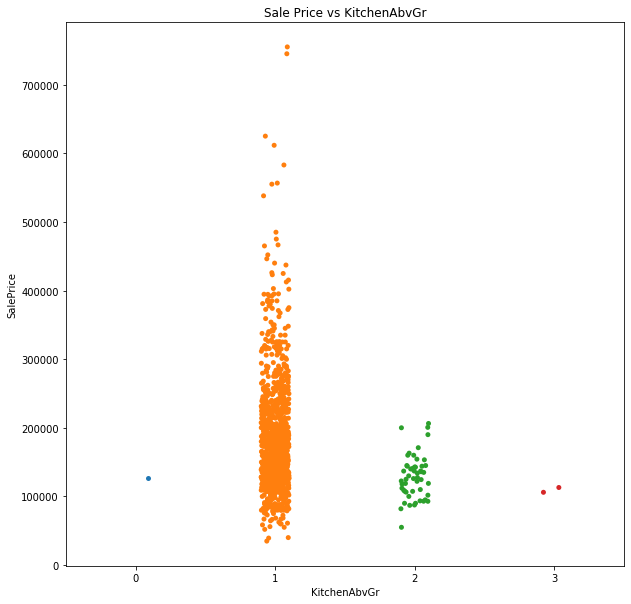

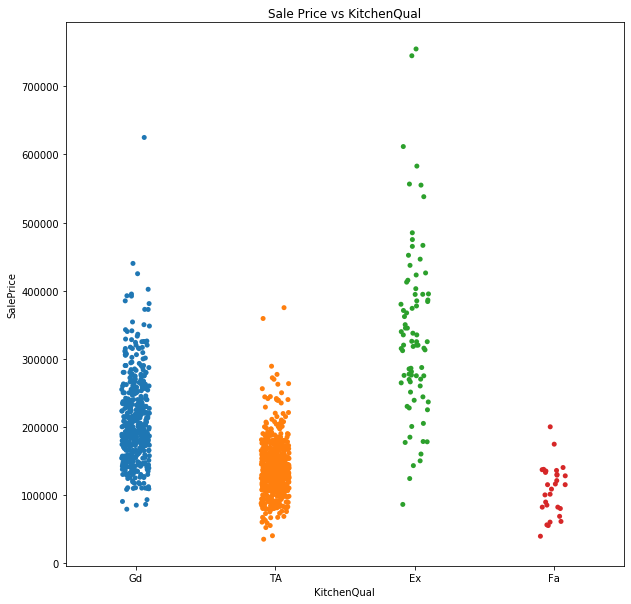

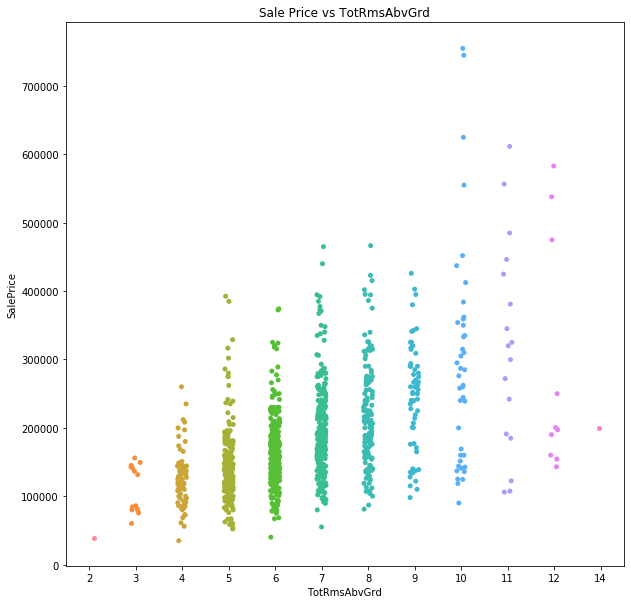

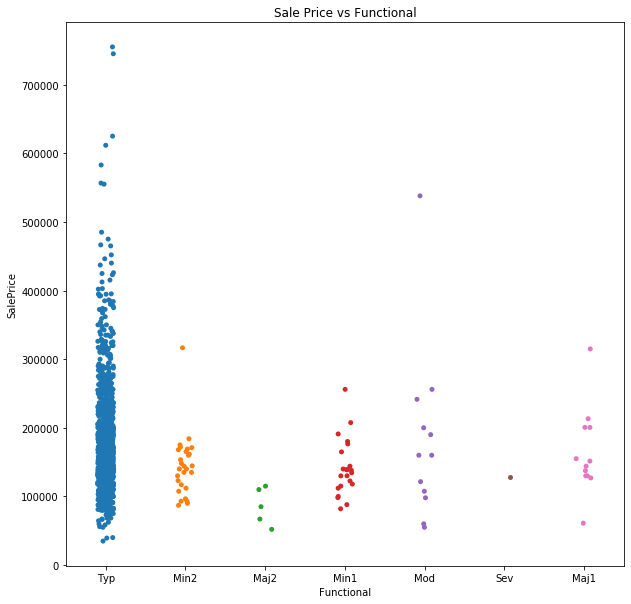

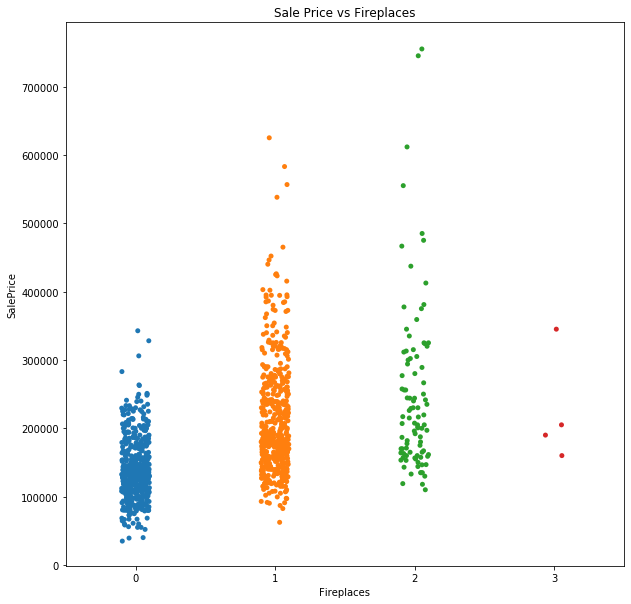

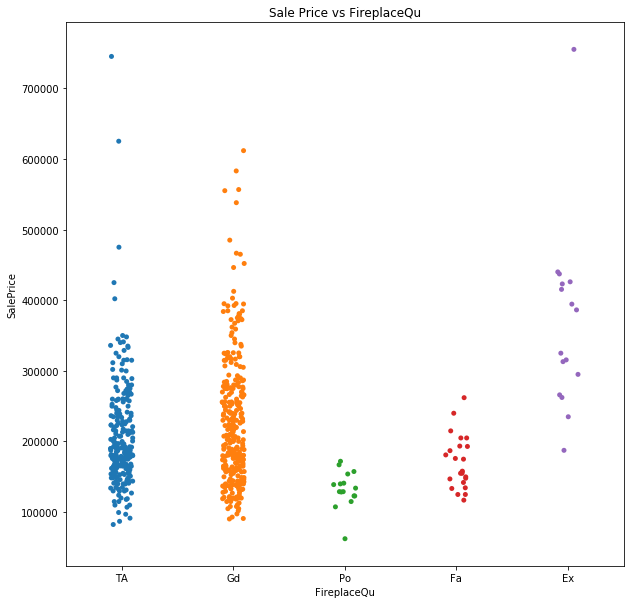

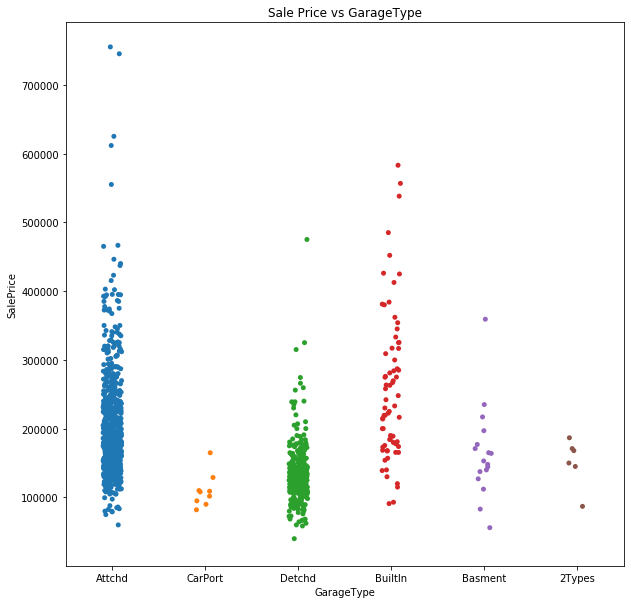

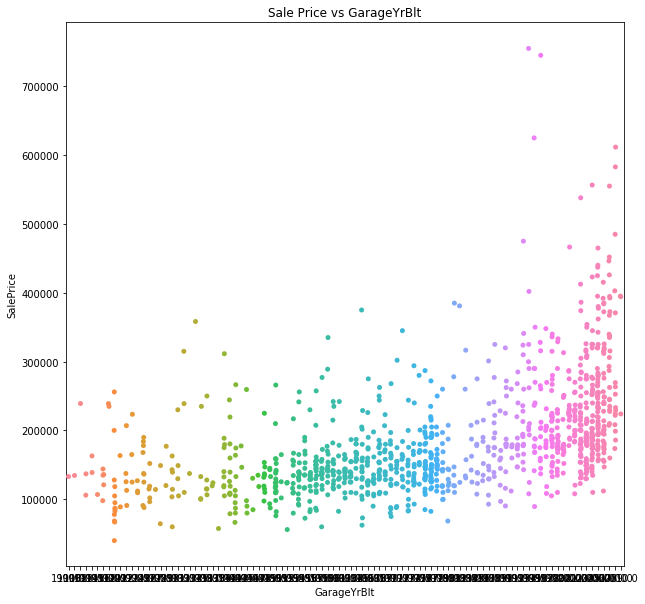

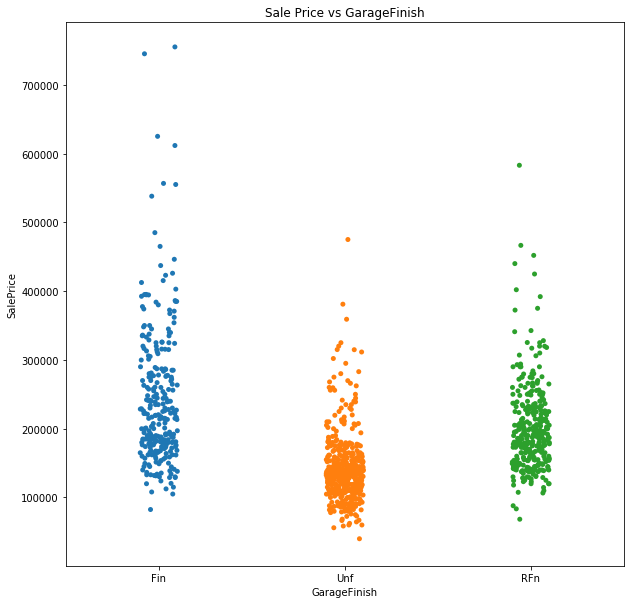

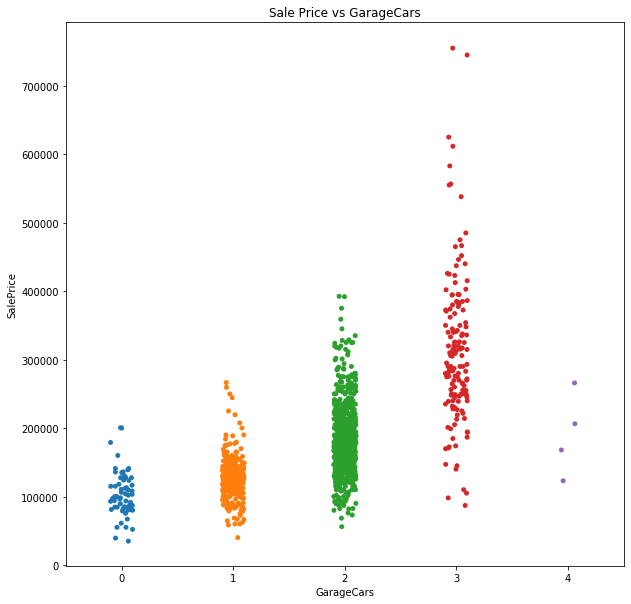

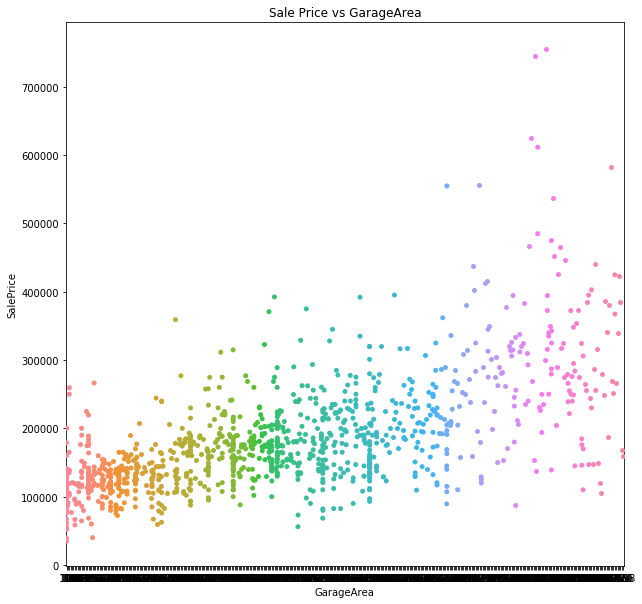

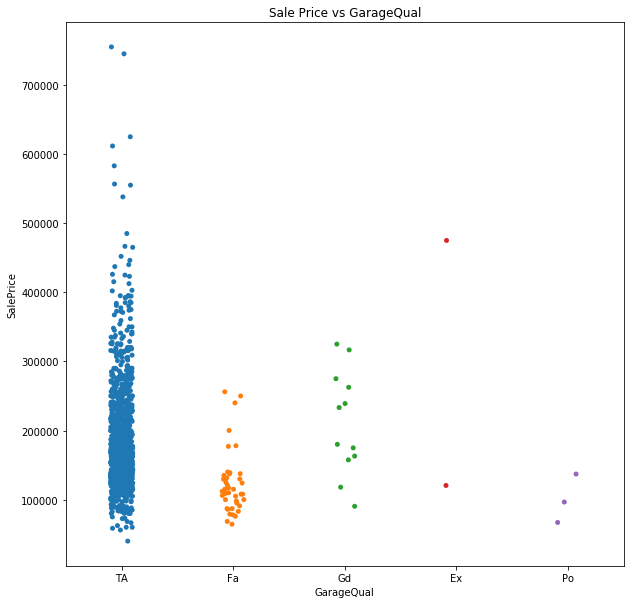

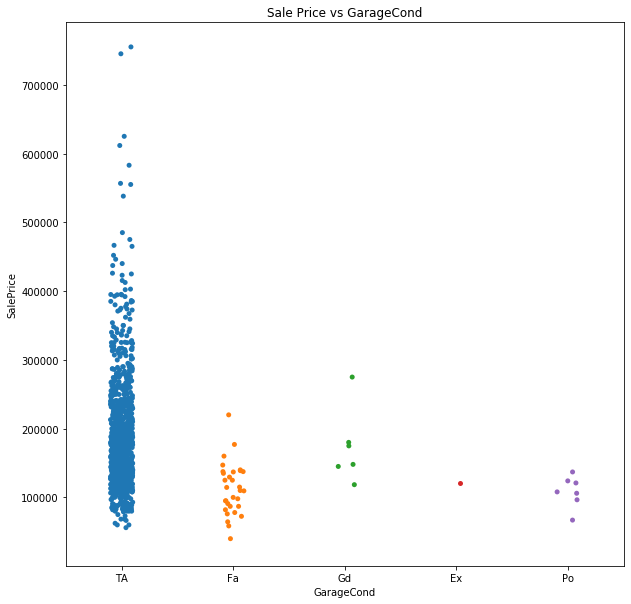

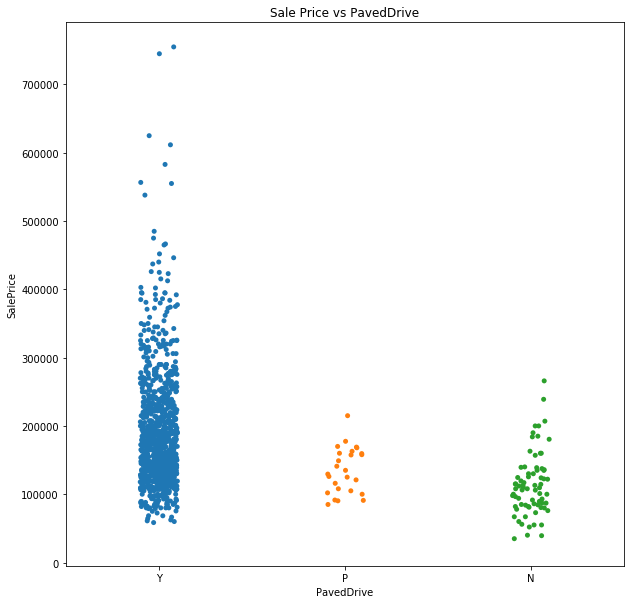

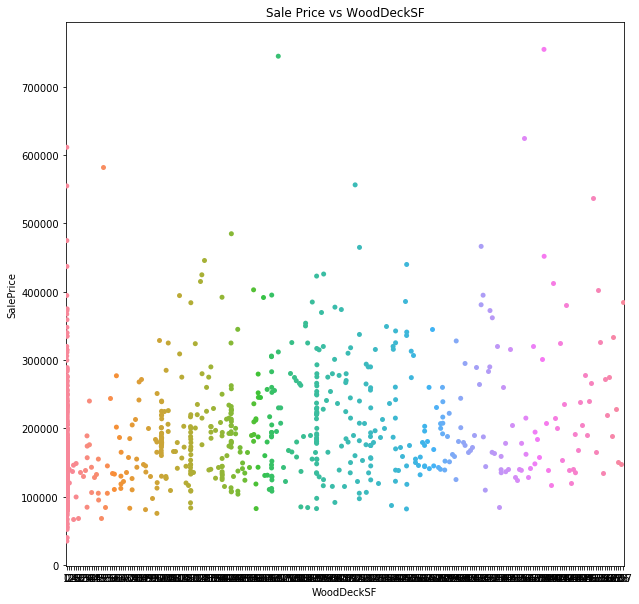

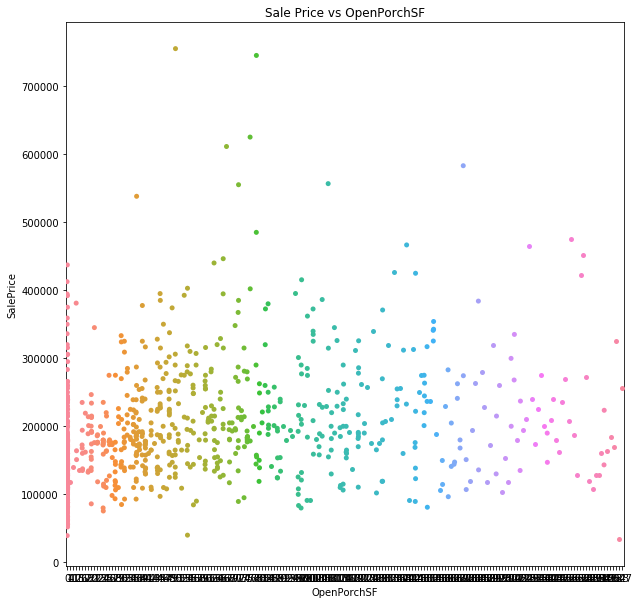

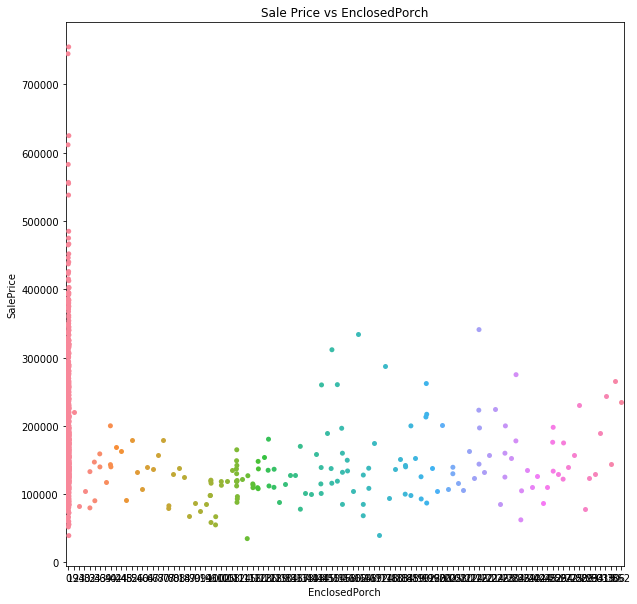

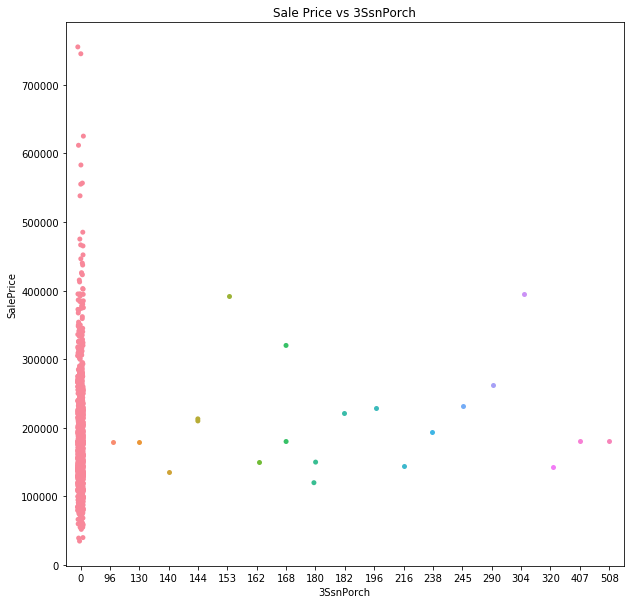

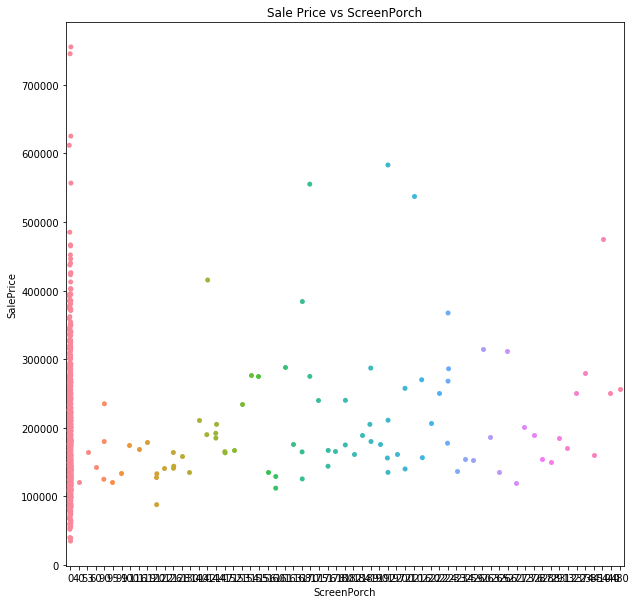

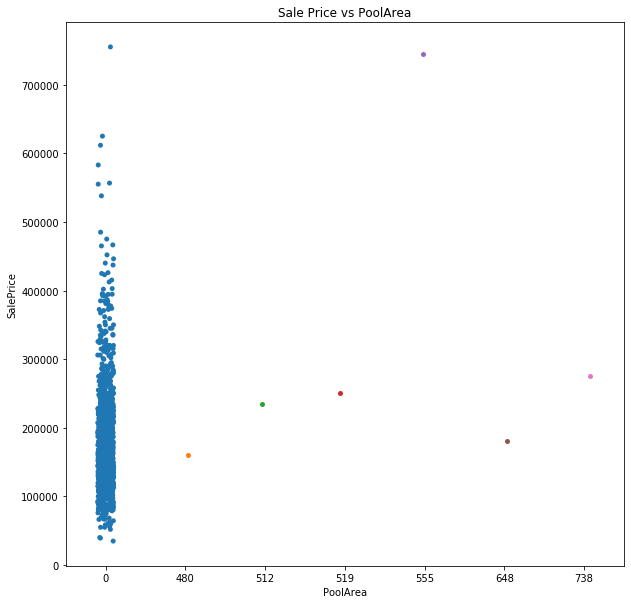

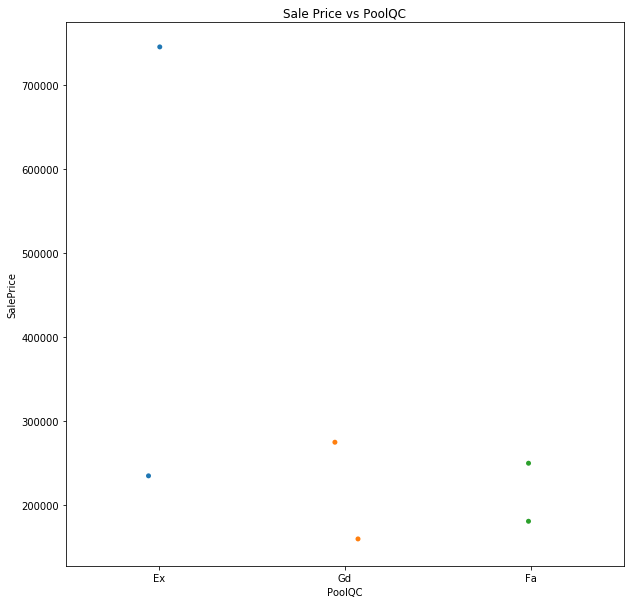

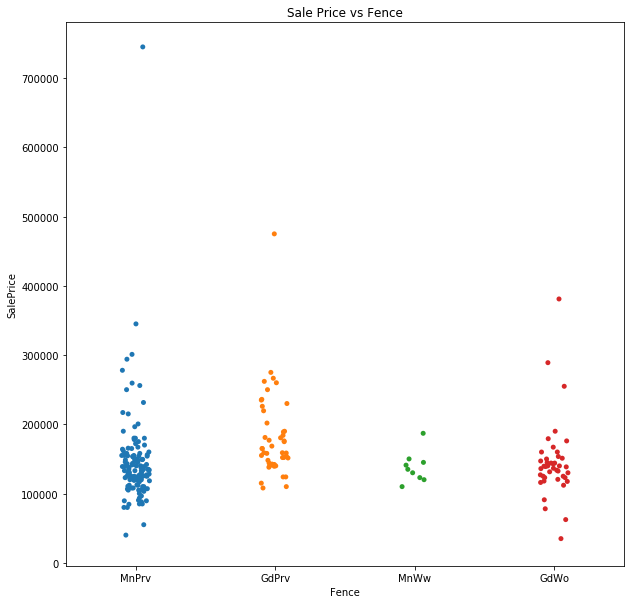

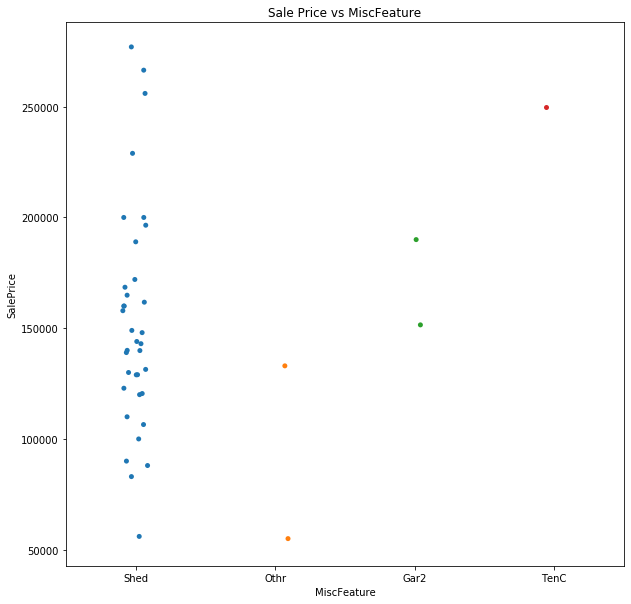

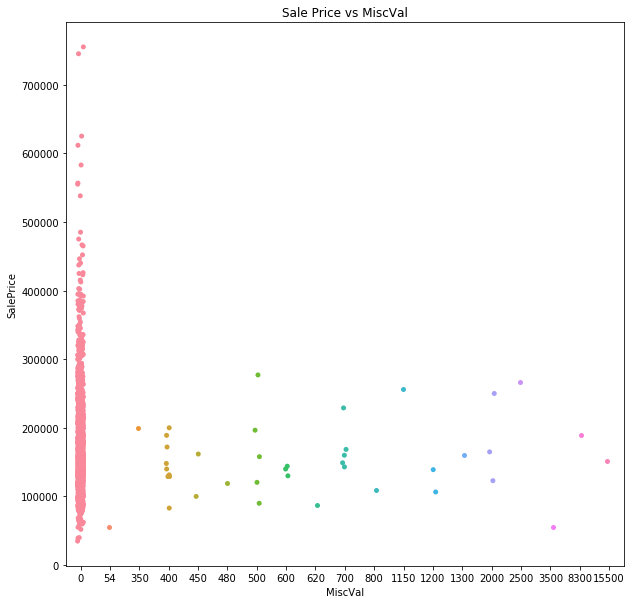

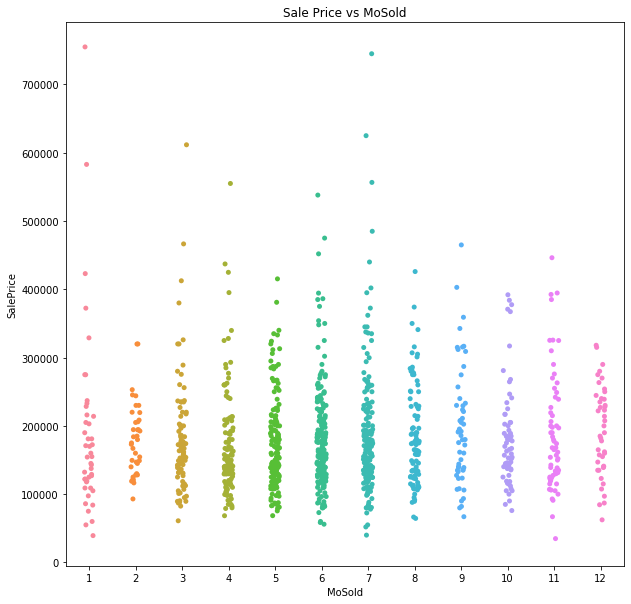

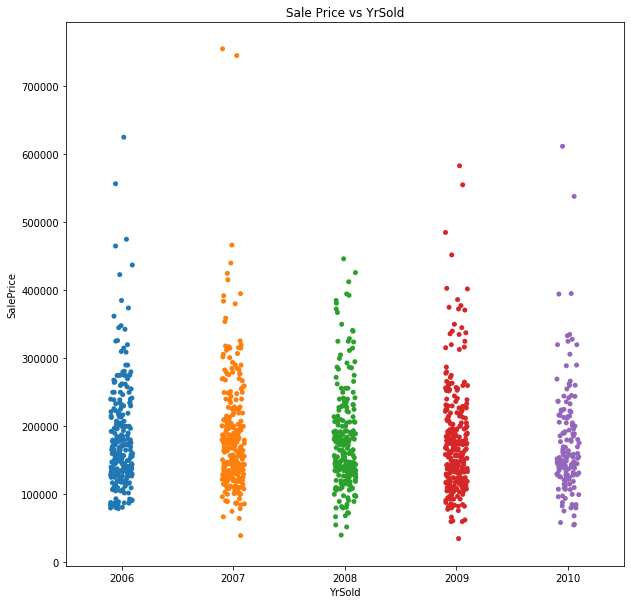

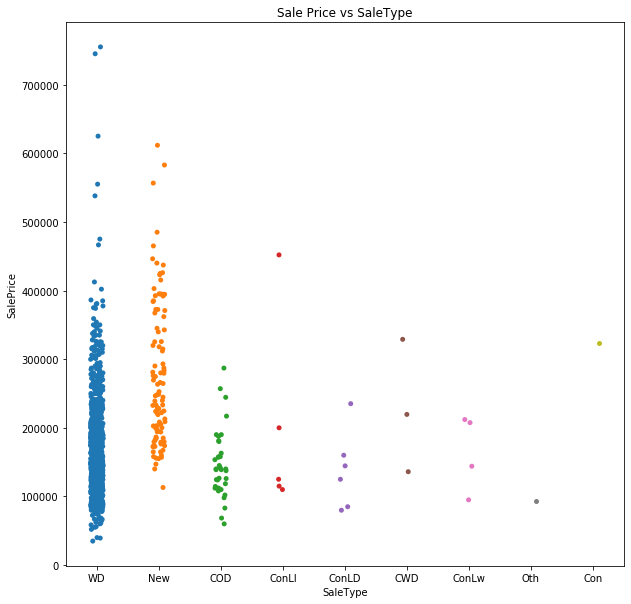

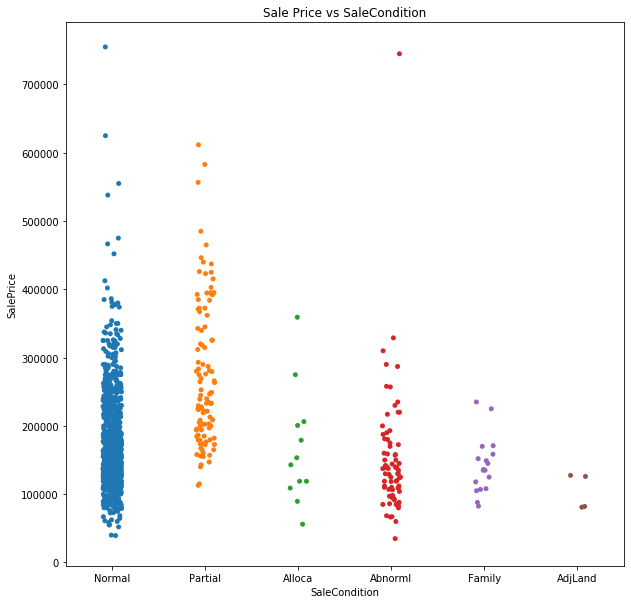

In [169]:
# Scatter Plots for all features vs target

for feature in train.columns:
    if feature != 'SalePrice':
        plt.figure(figsize = (10, 10))
        sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
        plt.title(f'Sale Price vs {feature}')
        plt.show()

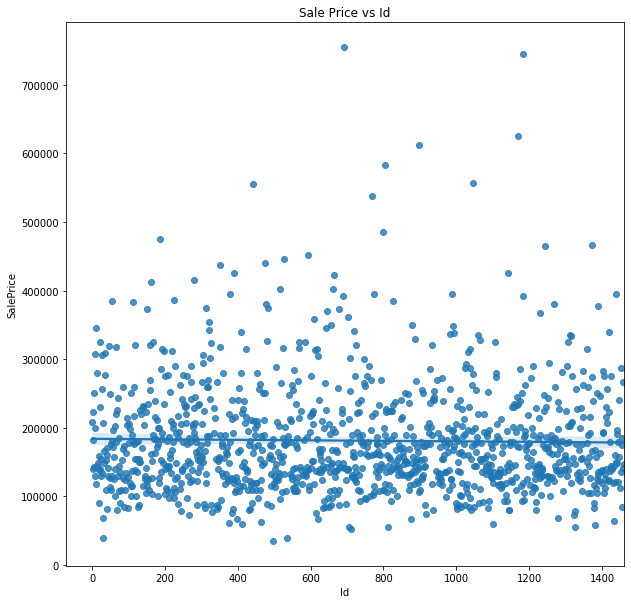

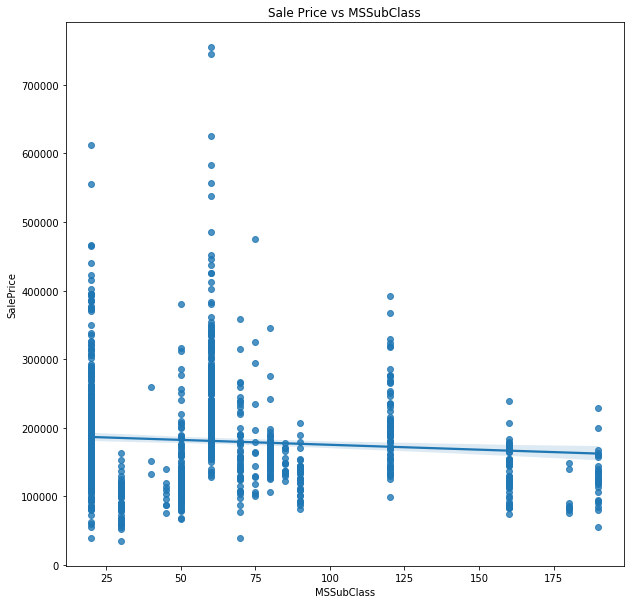

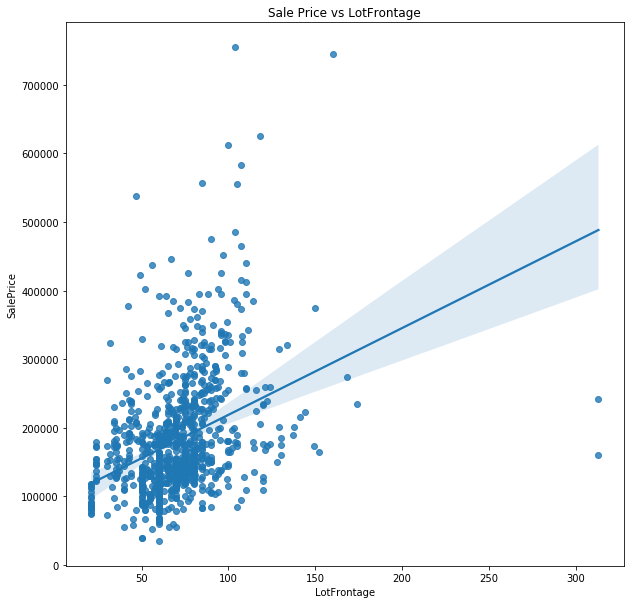

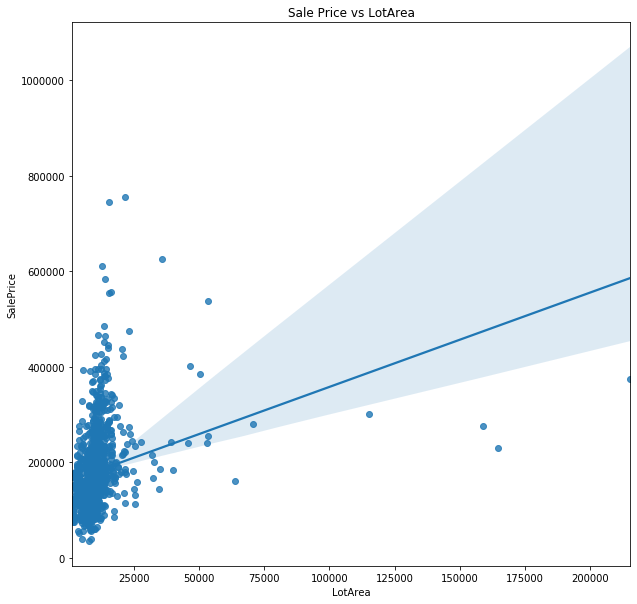

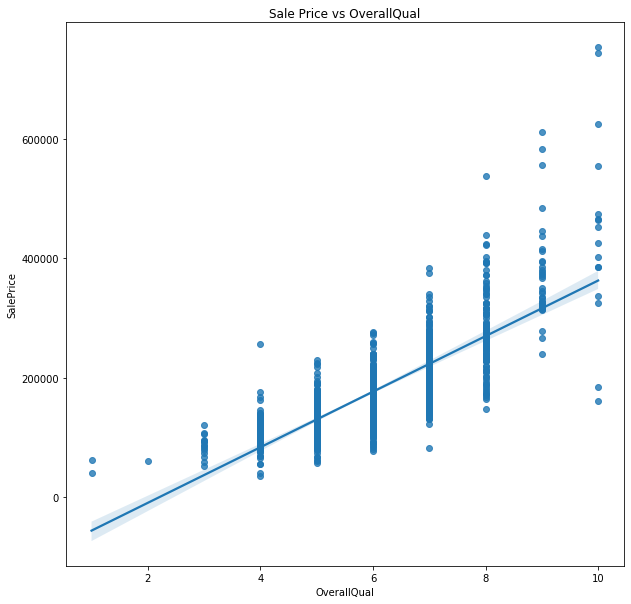

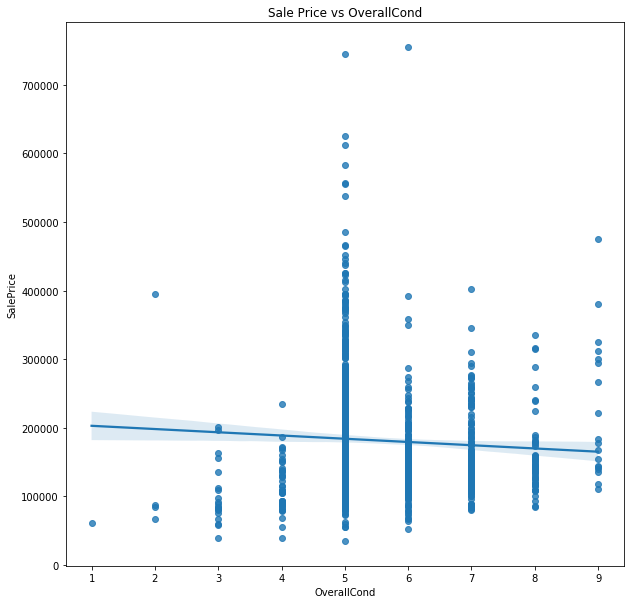

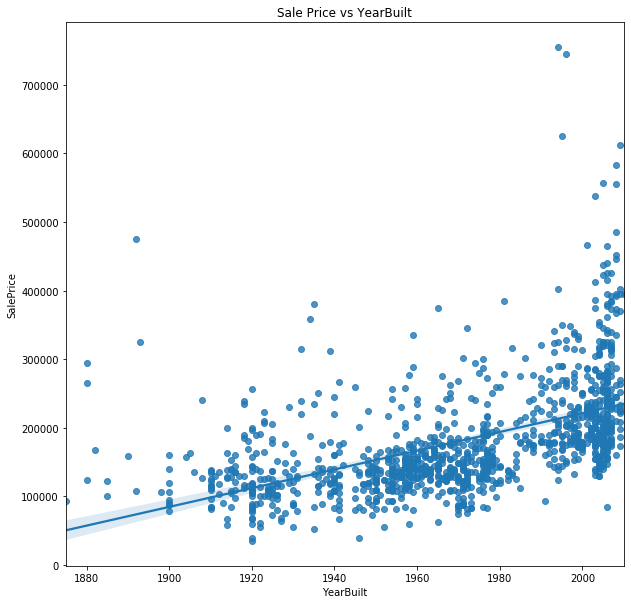

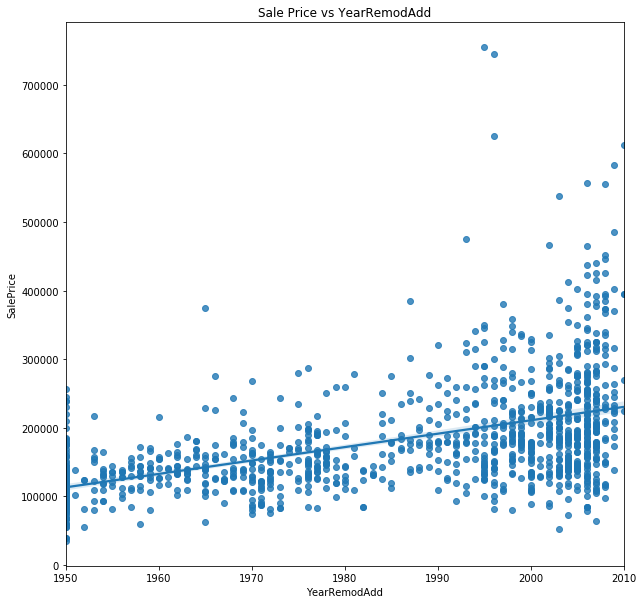

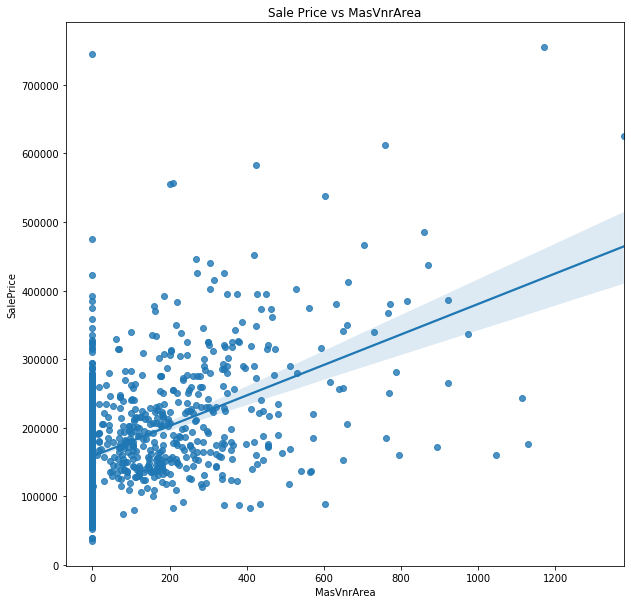

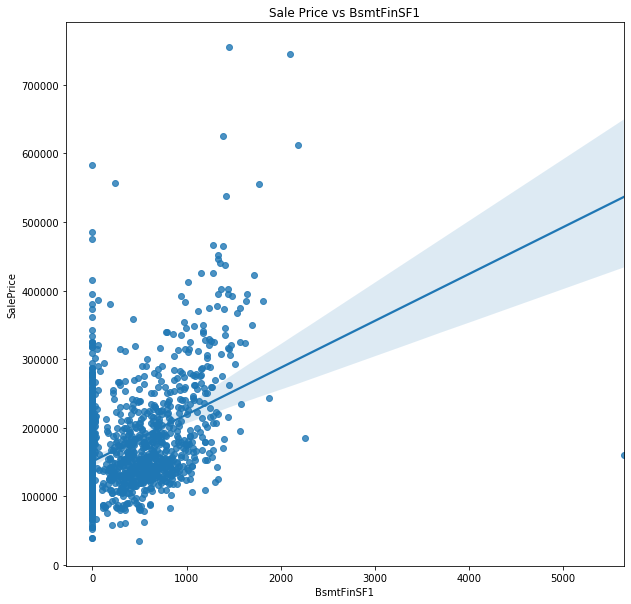

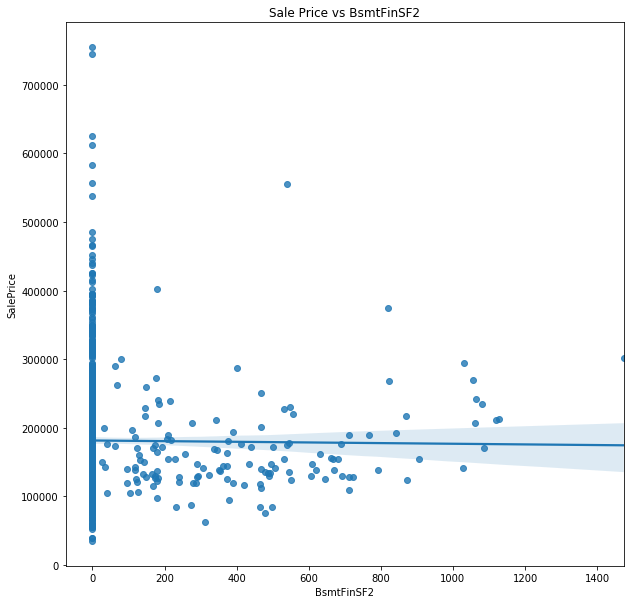

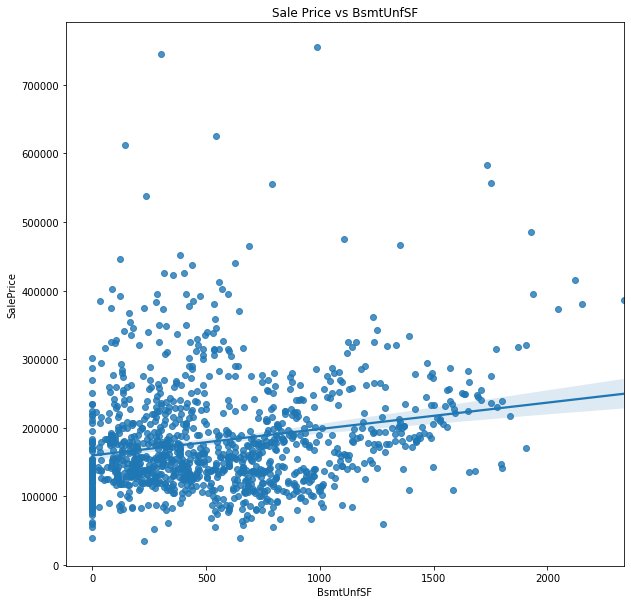

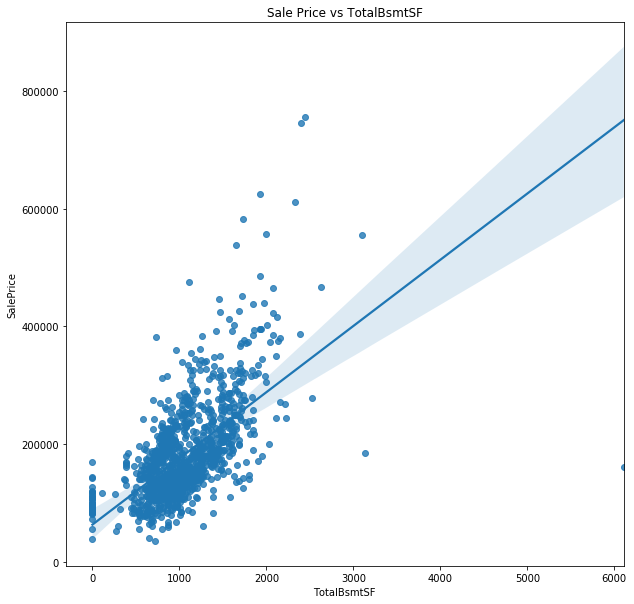

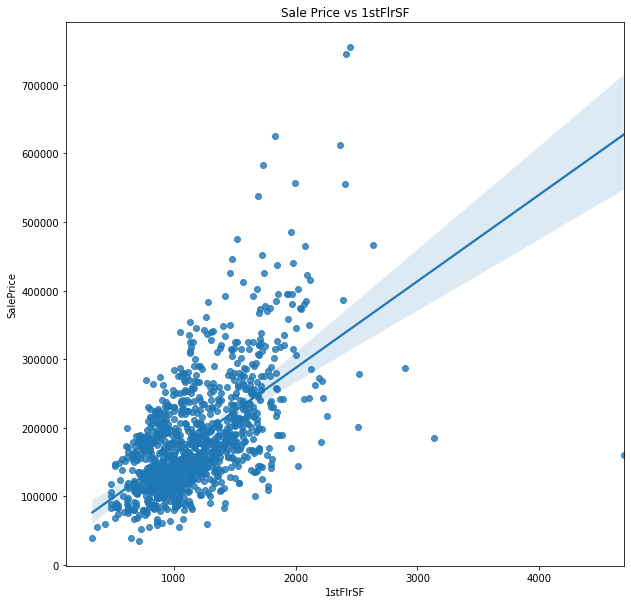

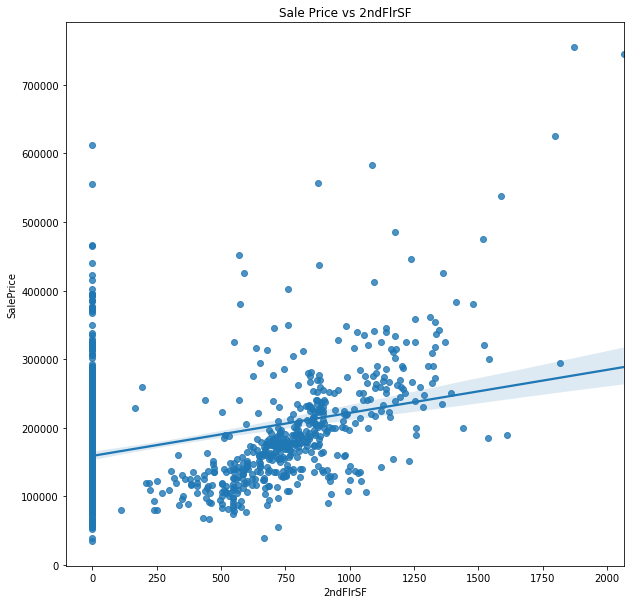

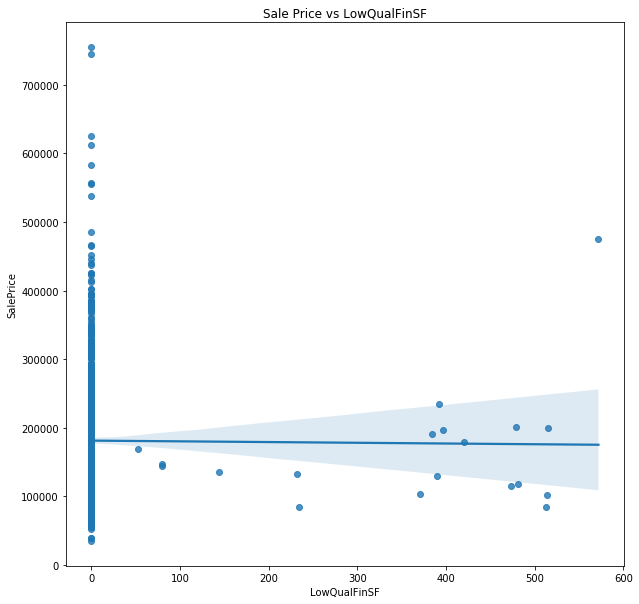

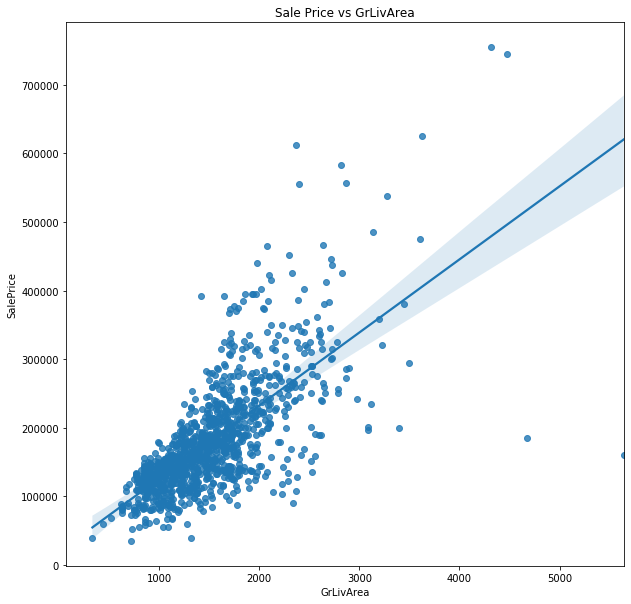

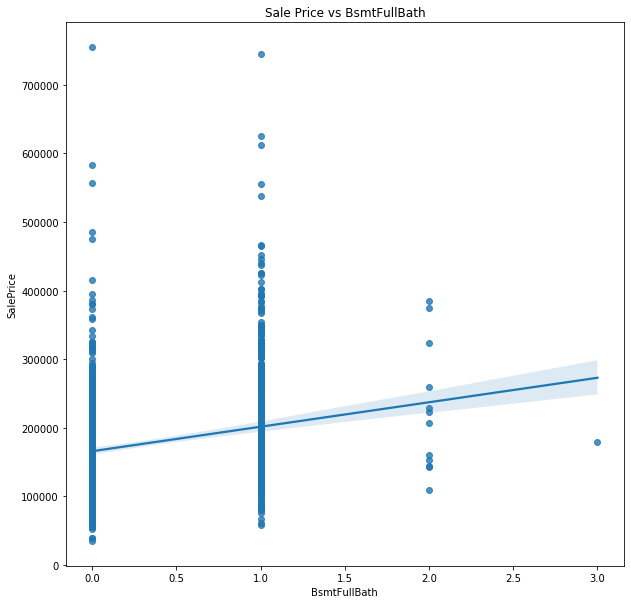

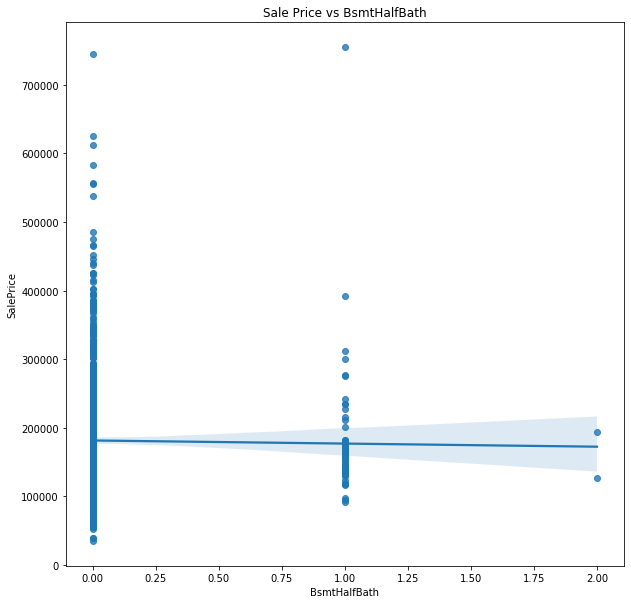

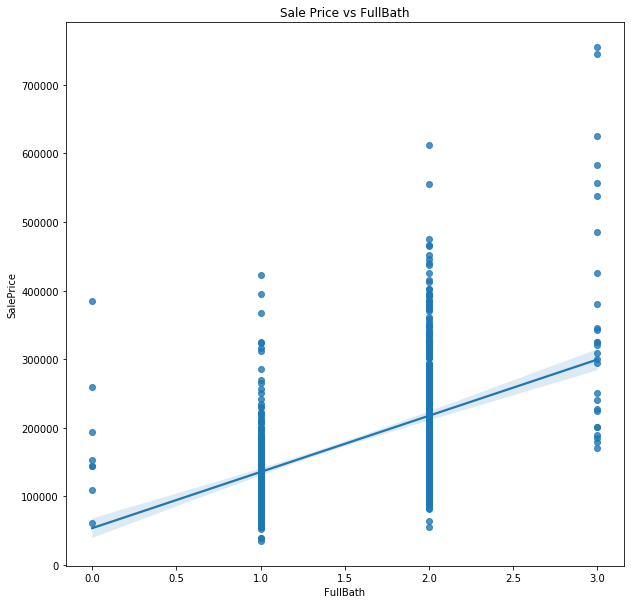

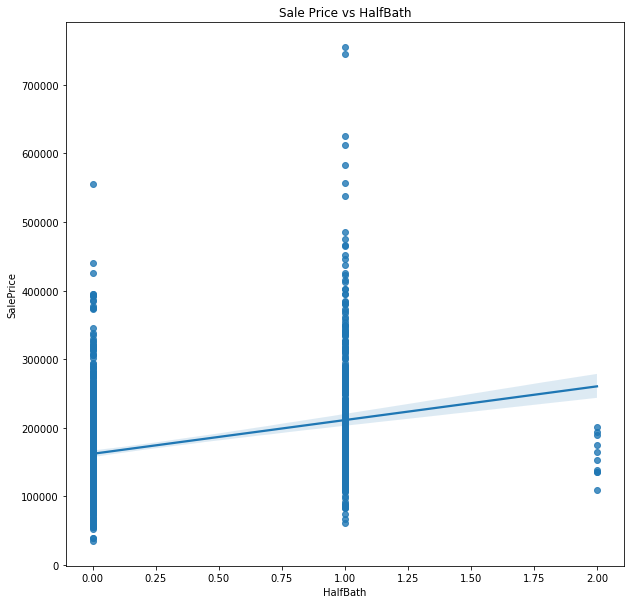

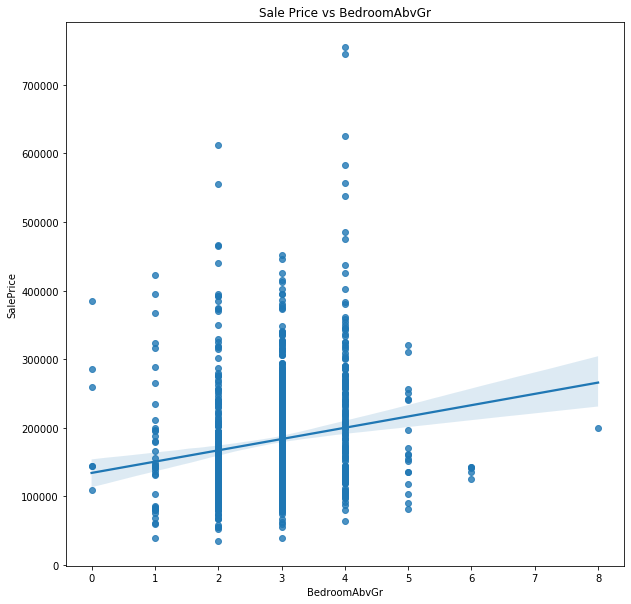

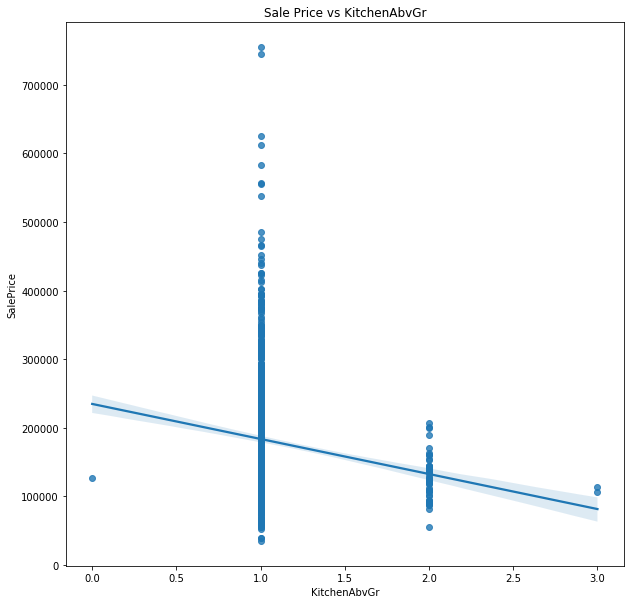

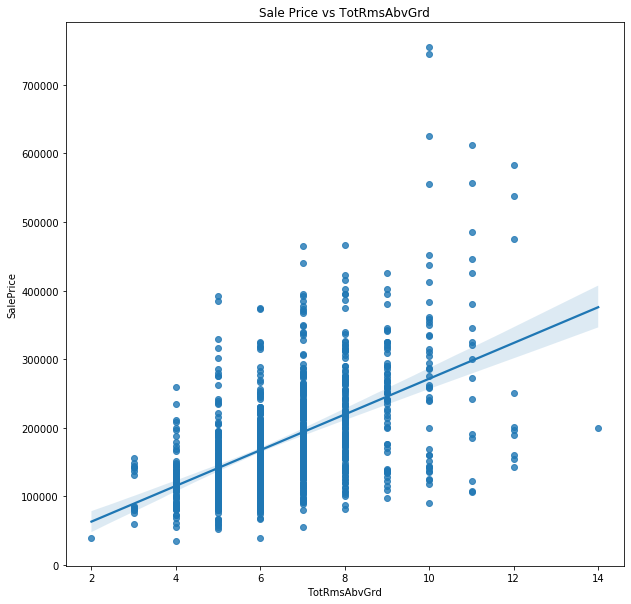

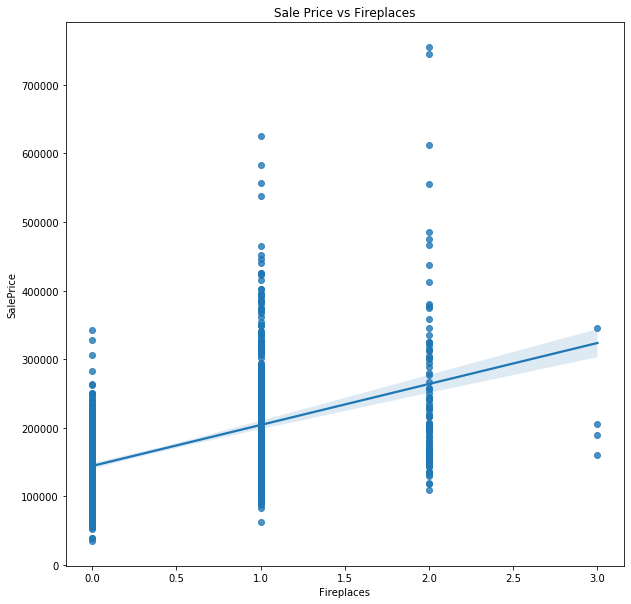

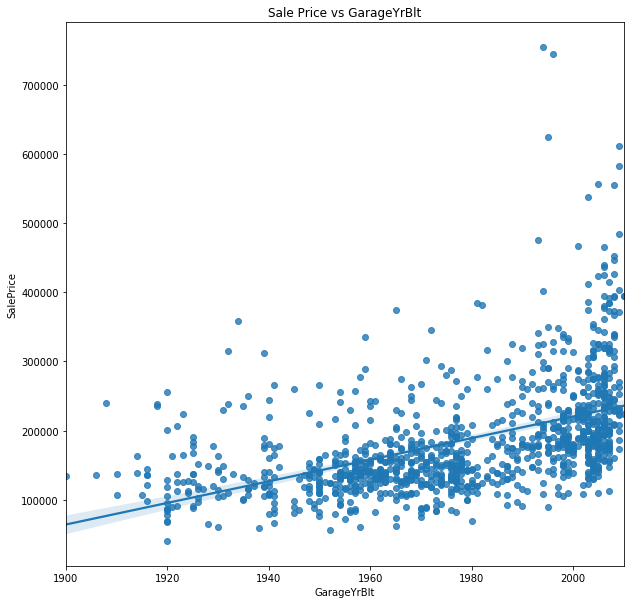

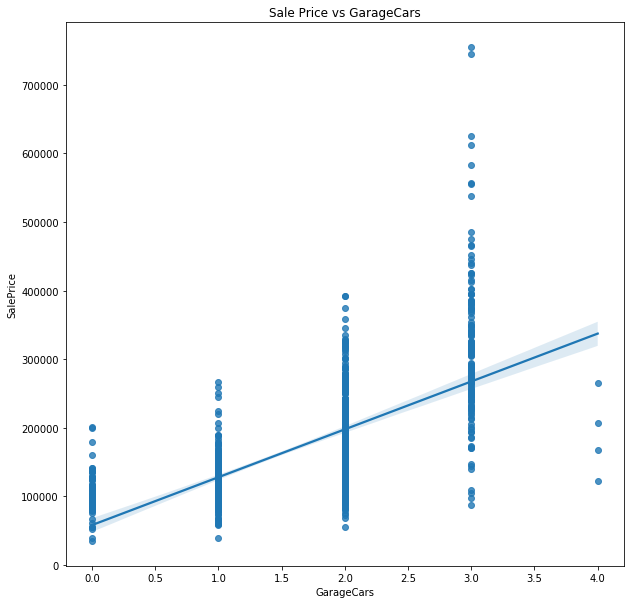

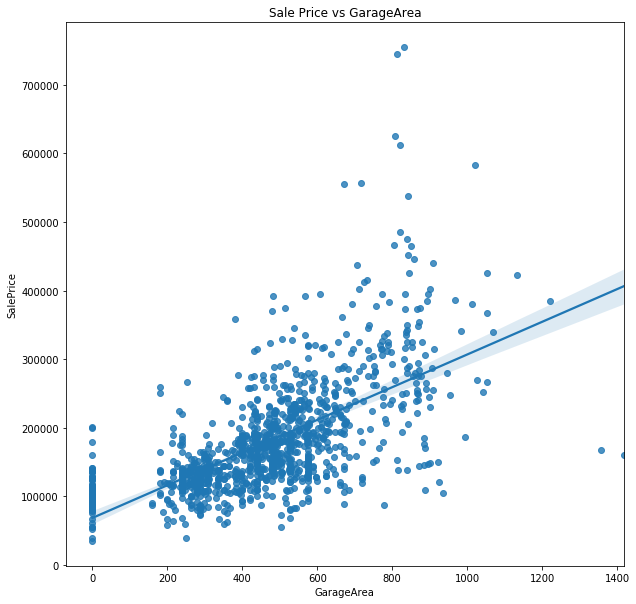

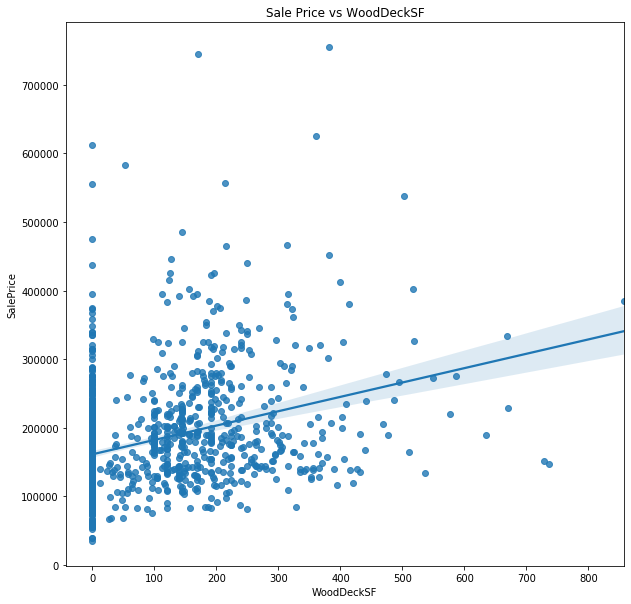

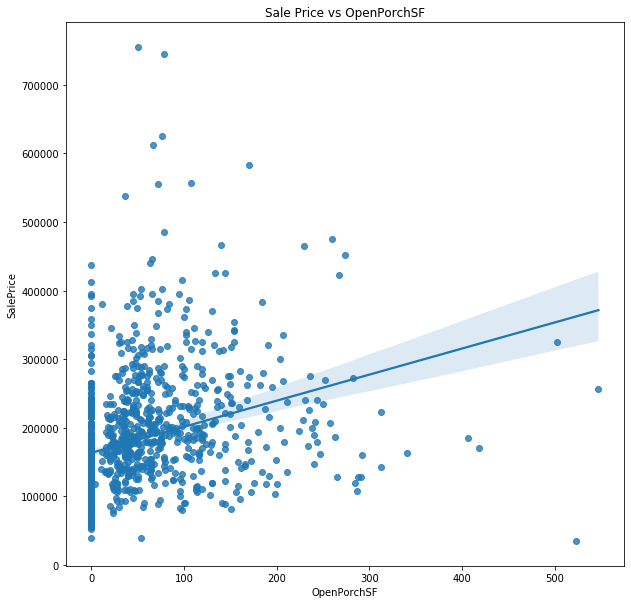

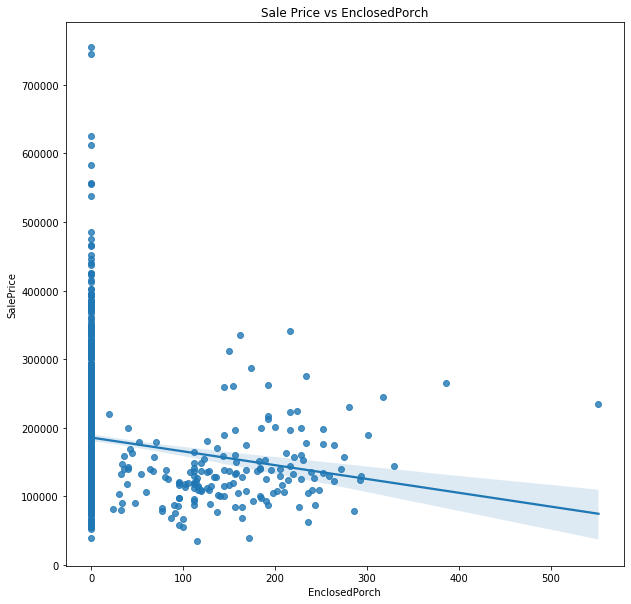

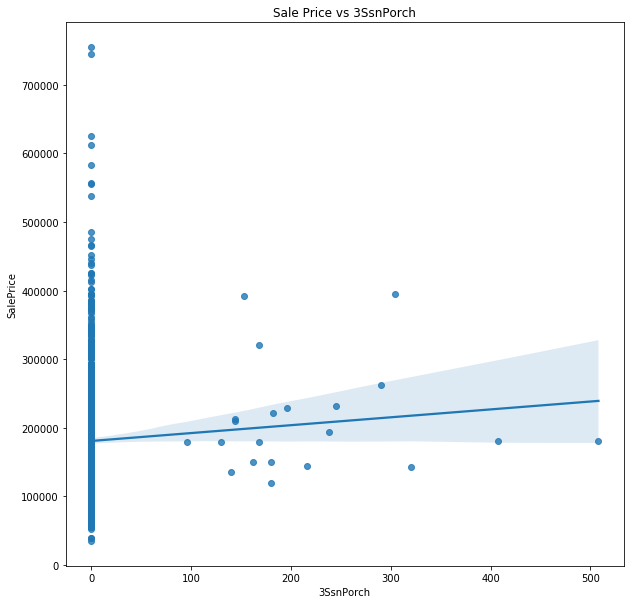

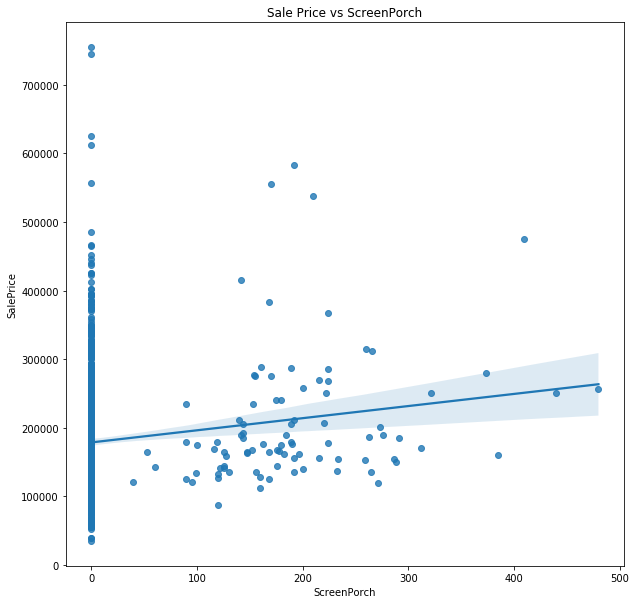

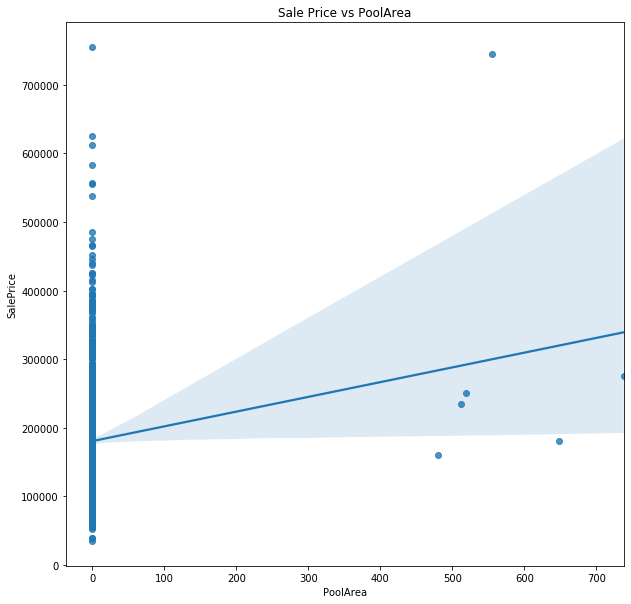

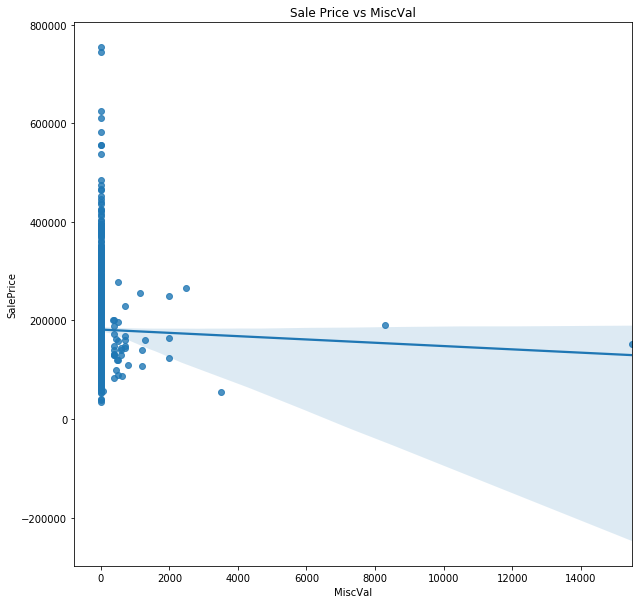

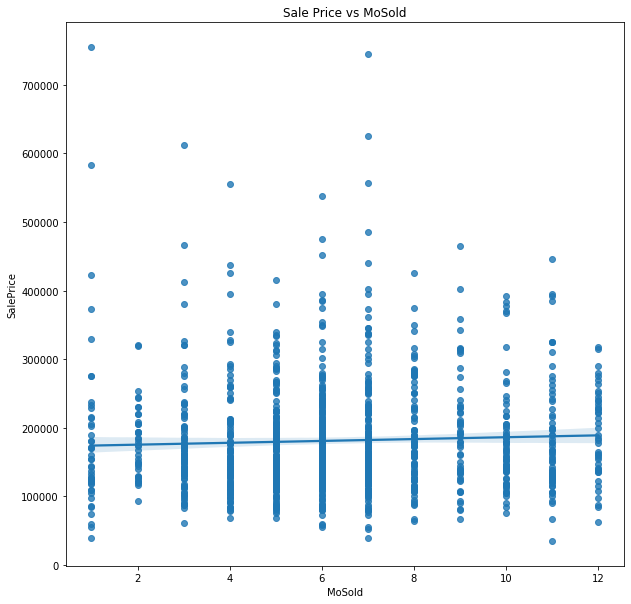

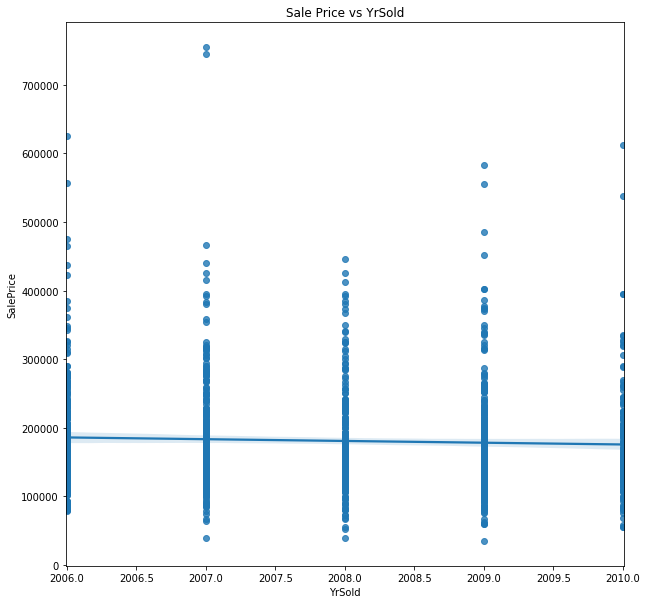

In [170]:
# Let's try to do regression only for numerical features vs target

count = 0

for feature in train.columns:
    if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
        count += 1
        plt.figure(figsize = (10, 10))
        plt.title(f'Sale Price vs {feature}')
        sns.regplot(x = feature, y = 'SalePrice', data = train)
        plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

Before we start selecting and training models, we have to preprocess our data. This includes things like dealing with missing values, encoding categorical features, and scaling the data to a normal range.

In [171]:
display(train)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
229    230         120       RL         43.0     3182   Pave   NaN      Reg   
52      53          90       RM        110.0     8472   Grvl   NaN      IR2   
861    862         190       RL         75.0    11625   Pave   NaN      Reg   
414    415          60       RL         59.0    11228   Pave   NaN      IR2   
852    853          75       RL         53.0     7128   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
560    561          20       RL          NaN    11341   Pave   NaN      IR1   
1414  1415          50       RL         64.0    13053   Pave  Pave      Reg   
502    503          20       RL         70.0     9170   Pave   NaN      Reg   
1196  1197          60       RL         58.0    14054   Pave   NaN      IR1   
1055  1056          20       RL        104.0    11361   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
229          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
52           Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
861          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
414          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
852          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
560          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1414         Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
502          Lvl    AllPub  ...        0    NaN  GdPrv        Shed     400   
1196         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1055         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
229       5   2009        WD         Normal     192500  
52        5   2010        WD         Normal     110000  
861       4   2010        WD         Normal     131500  
414      12   2008        WD         Normal     228000  
852       8   2007        WD         Normal     164000  
...     ...    ...       ...            ...        ...  
560       5   2010        WD         Normal     121500  
1414      6   2008        WD         Normal     207000  
502       4   2007        WD         Normal     140000  
1196     11   2006       New        Partial     219210  
1055      5   2008       COD        Abnorml     180000  

[1168 rows x 81 columns]

In [172]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [173]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1168.000000  1168.000000   974.000000    1168.000000  1168.000000   
mean    724.967466    57.714041    70.036961   10626.537671     6.107021   
std     421.851603    43.027029    24.632774   10862.515347     1.385326   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     355.250000    20.000000    59.000000    7500.000000     5.000000   
50%     726.500000    50.000000    69.000000    9402.500000     6.000000   
75%    1087.250000    70.000000    80.000000   11515.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1168.000000  1168.000000   1168.000000  1161.000000  1168.000000  ...   
mean      5.590753  1970.701199   1984.803938   101.523686   443.629281  ...   
std       1.113284    30.475167     20.798418   178.897750   462.478886  ...   
min       1.000000  1875.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1972.000000   1994.000000     0.000000   378.000000  ...   
75%       6.000000  2000.250000   2004.000000   161.000000   714.500000  ...   
max       9.000000  2010.000000   2010.000000  1378.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1168.000000  1168.000000    1168.000000  1168.000000  1168.000000   
mean     95.020548    46.785103      22.551370     3.913527    14.726027   
std     127.146521    67.026636      62.214179    31.767340    55.658251   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    24.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1168.000000   1168.000000  1168.000000  1168.000000    1168.000000  
mean      2.955479     47.306507     6.297945  2007.831336  181250.061644  
std      41.648504    548.366619     2.664038     1.335615   81484.281507  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129500.000000  
50%       0.000000      0.000000     6.000000  2008.000000  162250.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [174]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     194
Alley          1097
FireplaceQu     550
PoolQC         1162
Fence           941
MiscFeature    1127
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

LotFrontage Alley FireplaceQu PoolQC  Fence MiscFeature
229          43.0   NaN          TA    NaN    NaN         NaN
52          110.0   NaN         NaN    NaN    NaN         NaN
861          75.0   NaN         NaN    NaN    NaN         NaN
414          59.0   NaN          TA    NaN    NaN         NaN
852          53.0   NaN          Gd    NaN  MnPrv         NaN
...           ...   ...         ...    ...    ...         ...
560           NaN   NaN          Gd    NaN    NaN         NaN
1414         64.0  Pave          Gd    NaN    NaN         NaN
502          70.0   NaN         NaN    NaN  GdPrv        Shed
1196         58.0   NaN          Gd    NaN    NaN         NaN
1055        104.0   NaN          TA    NaN  MnPrv         NaN

[1168 rows x 6 columns]

All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [175]:
columns_to_drop = train.loc[:, train.isnull().sum() > len(train) * .15].columns
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
229    230         120       RL     3182   Pave      Reg         Lvl   
52      53          90       RM     8472   Grvl      IR2         Bnk   
861    862         190       RL    11625   Pave      Reg         Lvl   
414    415          60       RL    11228   Pave      IR2         Lvl   
852    853          75       RL     7128   Pave      Reg         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
560    561          20       RL    11341   Pave      IR1         Lvl   
1414  1415          50       RL    13053   Pave      Reg         Bnk   
502    503          20       RL     9170   Pave      Reg         Lvl   
1196  1197          60       RL    14054   Pave      IR1         Lvl   
1055  1056          20       RL    11361   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
229     AllPub    Inside       Gtl  ...             0         0           0   
52      AllPub    Corner       Mod  ...             0         0           0   
861     AllPub    Inside       Gtl  ...             0         0           0   
414     AllPub   CulDSac       Gtl  ...             0         0           0   
852     AllPub    Inside       Gtl  ...             0         0         126   
...        ...       ...       ...  ...           ...       ...         ...   
560     AllPub    Inside       Gtl  ...             0         0          95   
1414    AllPub    Inside       Gtl  ...             0         0         220   
502     AllPub    Corner       Gtl  ...           184         0           0   
1196    AllPub    Inside       Gtl  ...             0         0           0   
1055    AllPub    Inside       Gtl  ...             0         0         189   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
229         0       0       5    2009        WD         Normal    192500  
52          0       0       5    2010        WD         Normal    110000  
861         0       0       4    2010        WD         Normal    131500  
414         0       0      12    2008        WD         Normal    228000  
852         0       0       8    2007        WD         Normal    164000  
...       ...     ...     ...     ...       ...            ...       ...  
560         0       0       5    2010        WD         Normal    121500  
1414        0       0       6    2008        WD         Normal    207000  
502         0     400       4    2007        WD         Normal    140000  
1196        0       0      11    2006       New        Partial    219210  
1055        0       0       5    2008       COD        Abnorml    180000  

[1168 rows x 75 columns]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
1456  1457          20       RL    13175   Pave      Reg         Lvl   
297    298          60       FV     7399   Pave      IR1         Lvl   
1433  1434          60       RL    10261   Pave      IR1         Lvl   
508    509          70       RM     9600   Pave      Reg         Lvl   
1104  1105         160       RM     2016   Pave      Reg         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
995    996          50       RL     4712   Pave      IR1         Lvl   
595    596          20       RL    11302   Pave      IR1         Lvl   
82      83          20       RL    10206   Pave      Reg         Lvl   
277    278          20       RL    19138   Pave      Reg         Lvl   
1220  1221          20       RL     7800   Pave      IR1         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
1456    AllPub    Inside       Gtl  ...             0         0           0   
297     AllPub    Inside       Gtl  ...             0         0         198   
1433    AllPub    Inside       Gtl  ...             0         0           0   
508     AllPub    Inside       Gtl  ...           116         0           0   
1104    AllPub    Inside       Gtl  ...             0         0           0   
...        ...       ...       ...  ...           ...       ...         ...   
995     AllPub    Inside       Mod  ...             0         0          63   
595     AllPub    Inside       Gtl  ...             0         0         120   
82      AllPub    Inside       Gtl  ...             0         0           0   
277     AllPub    Corner       Gtl  ...             0         0           0   
1220    AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
1456        0       0       2    2010        WD         Normal    210000  
297         0       0       6    2007        WD         Normal    239000  
1433        0       0       5    2008        WD         Normal    186500  
508         0       0      10    2008        WD         Normal    161000  
1104        0       0       4    2007        WD         Normal    106000  
...       ...     ...     ...     ...       ...            ...       ...  
995         0       0       8    2006        WD        Abnorml    121600  
595         0       0       8    2006       New        Partial    319000  
82          0       0      10    2008        WD         Normal    245000  
277         0       0       6    2010        WD         Normal    141000  
1220        0       0      11    2006        WD        Abnorml    115000  

[292 rows x 75 columns]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
0     1461          20       RH    11622   Pave      Reg         Lvl   
1     1462          20       RL    14267   Pave      IR1         Lvl   
2     1463          60       RL    13830   Pave      IR1         Lvl   
3     1464          60       RL     9978   Pave      IR1         Lvl   
4     1465         120       RL     5005   Pave      IR1         HLS   
...    ...         ...      ...      ...    ...      ...         ...   
1454  2915         160       RM     1936   Pave      Reg         Lvl   
1455  2916         160       RM     1894   Pave      Reg         Lvl   
1456  2917          20       RL    20000   Pave      Reg         Lvl   
1457  2918          85       RL    10441   Pave      Reg         Lvl   
1458  2919          60       RL     9627   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0       AllPub    Inside       Gtl  ...           0             0         0   
1       AllPub    Corner       Gtl  ...          36             0         0   
2       AllPub    Inside       Gtl  ...          34             0         0   
3       AllPub    Inside       Gtl  ...          36             0         0   
4       AllPub    Inside       Gtl  ...          82             0         0   
...        ...       ...       ...  ...         ...           ...       ...   
1454    AllPub    Inside       Gtl  ...           0             0         0   
1455    AllPub    Inside       Gtl  ...          24             0         0   
1456    AllPub    Inside       Gtl  ...           0             0         0   
1457    AllPub    Inside       Gtl  ...          32             0         0   
1458    AllPub    Inside       Mod  ...          48             0         0   

     ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleType SaleCondition  
0            120        0        0       6    2010        WD        Normal  
1              0        0    12500       6    2010        WD        Normal  
2              0        0        0       3    2010        WD        Normal  
3              0        0        0       6    2010        WD        Normal  
4            144        0        0       1    2010        WD        Normal  
...          ...      ...      ...     ...     ...       ...           ...  
1454           0        0        0       6    2006        WD        Normal  
1455           0        0        0       4    2006        WD       Abnorml  
1456           0        0        0       9    2006        WD       Abnorml  
1457           0        0      700       7    2006        WD        Normal  
1458           0        0        0      11    2006        WD        Normal  

[1459 rows x 74 columns]

That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [176]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [177]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [178]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
229        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
52         RM   Grvl      IR2         Bnk    AllPub    Corner       Mod   
861        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
414        RL   Pave      IR2         Lvl    AllPub   CulDSac       Gtl   
852        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
560        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
1414       RL   Pave      Reg         Bnk    AllPub    Inside       Gtl   
502        RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
1196       RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
1055       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2  ... Electrical KitchenQual  \
229       Blmngtn       Norm       Norm  ...      SBrkr          Gd   
52         IDOTRR       RRNn       Norm  ...      SBrkr          TA   
861        Sawyer       Norm       Norm  ...      SBrkr          TA   
414       SawyerW       Norm       Norm  ...      SBrkr          Gd   
852       Crawfor       Norm       Norm  ...      SBrkr          TA   
...           ...        ...        ...  ...        ...         ...   
560        Sawyer       Norm       Norm  ...      SBrkr          TA   
1414      BrkSide       Norm       Norm  ...      SBrkr          Gd   
502       Edwards      Feedr       Norm  ...      SBrkr          TA   
1196      Gilbert       Norm       Norm  ...      SBrkr          Gd   
1055       NWAmes       Norm       Norm  ...      SBrkr          TA   

     Functional GarageType GarageFinish GarageQual GarageCond PavedDrive  \
229         Typ     Attchd          Fin         TA         TA          Y   
52          Typ    CarPort          Unf         TA         TA          Y   
861         Typ     Attchd          Unf         TA         TA          Y   
414         Typ     Attchd          Unf         TA         TA          Y   
852         Typ     Detchd          Unf         TA         TA          Y   
...         ...        ...          ...        ...        ...        ...   
560         Mod     Detchd          Unf         TA         TA          Y   
1414        Typ     Detchd          Unf         TA         TA          N   
502         Typ     Detchd          Unf         Fa         Fa          Y   
1196        Typ    BuiltIn          Fin         TA         TA          Y   
1055        Typ     Attchd          Fin         TA         TA          Y   

     SaleType SaleCondition  
229        WD        Normal  
52         WD        Normal  
861        WD        Normal  
414        WD        Normal  
852        WD        Normal  
...       ...           ...  
560        WD        Normal  
1414       WD        Normal  
502        WD        Normal  
1196      New       Partial  
1055      COD       Abnorml  

[1168 rows x 38 columns]

Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:  
1. LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [179]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [180]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
229        3.0          3          2          3          2         4   
52         0.0          3          1          1          2         4   
861        3.0          3          2          2          2         3   
414        0.0          3          2          3          2         4   
852        3.0          3          2          2          3         3   
...        ...        ...        ...        ...        ...       ...   
560        2.0          3          2          2          2         4   
1414       3.0          3          2          2          2         3   
502        3.0          3          2          2          2         3   
1196       2.0          3          2          3          2         4   
1055       3.0          3          2          2          2         4   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
229          3             3             5             1          4   
52           3             4             2             5          2   
861          3             2             3             1          4   
414          3             1             3             5          4   
852          3             1             4             1          3   
...        ...           ...           ...           ...        ...   
560          3             1             4             1          2   
1414         3             1             1             1          3   
502          3             1             4             5          4   
1196         3             3             1             1          4   
1055         3             1             4             1          2   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
229            1         3.0            3           7             3   
52             0         3.0            2           7             1   
861            1         3.0            2           7             1   
414            1         3.0            3           7             1   
852            1         3.0            2           7             1   
...          ...         ...          ...         ...           ...   
560            1         3.0            2           4             1   
1414           1         3.0            3           7             1   
502            1         3.0            2           7             1   
1196           1         3.0            3           7             3   
1055           1         3.0            2           7             3   

      GarageQual  GarageCond  PavedDrive  
229            3           3           2  
52             3           3           2  
861            3           3           2  
414            3           3           2  
852            3           3           2  
...          ...         ...         ...  
560            3           3           2  
1414           3           3           0  
502            2           2           2  
1196           3           3           2  
1055           3           3           2  

[1168 rows x 19 columns]

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
1456       3.0          3          2          2          2         4   
297        2.0          3          2          3          2         4   
1433       2.0          3          2          2          2         4   
508        3.0          3          2          2          4         3   
1104       3.0          3          2          2          2         3   
...        ...        ...        ...        ...        ...       ...   
995        2.0          3          1          2          2         3   
595        2.0          3          2          3          2         4   
82         3.0          3          2          2          2         4   
277        3.0          3          2          2          2         3   
1220       2.0          3          2          2          2         3   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
1456         3             1             4             4          2   
297          3             1             3             1          4   
1433         3             1             1             1          4   
508          3             1             4             1          4   
1104         3             1             1             1          2   
...        ...           ...           ...           ...        ...   
995          3             1             4             1          2   
595          3             4             5             1          4   
82           3             1             5             1          4   
277          3             1             2             1          4   
1220         3             1             4             2          2   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
1456           1           3            2           6             1   
297            1           3            3           7             2   
1433           1           3            2           7             3   
508            1           3            3           7             1   
1104           1           3            2           7             1   
...          ...         ...          ...         ...           ...   
995            1           3            2           7             1   
595            1           3            3           7             3   
82             1           3            3           7             2   
277            1           3            2           7             1   
1220           1           3            2           7             1   

      GarageQual  GarageCond  PavedDrive  
1456           3           3           2  
297            3           3           2  
1433           3           3           2  
508            3           3           0  
1104           3           3           2  
...          ...         ...         ...  
995            3           3           2  
595            3           3           2  
82             3           3           2  
277            3           3           2  
1220           3           3           2  

[292 rows x 19 columns]

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
0          3.0          3          2          2          2         3   
1          2.0          3          2          2          2         3   
2          2.0          3          2          2          2         4   
3          2.0          3          2          2          2         3   
4          2.0          3          2          3          2         4   
...        ...        ...        ...        ...        ...       ...   
1454       3.0          3          2          2          2         3   
1455       3.0          3          2          2          2         3   
1456       3.0          3          2          2          2         3   
1457       3.0          3          2          2          2         4   
1458       3.0          3          1          2          2         4   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
0            3             1             4             2          2   
1            3             1             4             1          2   
2            3             1             5             1          3   
3            3             1             5             1          4   
4            3             1             4             1          4   
...        ...           ...           ...           ...        ...   
1454         3             1             1             1          3   
1455         3             1             4             1          2   
1456         3             1             4             1          4   
1457         3             3             5             1          2   
1458         3             3             2             1          4   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
0              1           3            2           7             1   
1              1           3            3           7             1   
2              1           3            2           7             3   
3              1           3            3           7             3   
4              1           3            3           7             2   
...          ...         ...          ...         ...           ...   
1454           1           3            2           7             1   
1455           1           3            2           7             1   
1456           1           3            2           7             1   
1457           1           3            2           7             1   
1458           1           3            2           7             3   

      GarageQual  GarageCond  PavedDrive  
0              3           3           2  
1              3           3           2  
2              3           3           2  
3              3           3           2  
4              3           3           2  
...          ...         ...         ...  
1454           3           3           2  
1455           3           3           2  
1456           3           3           2  
1457           3           3           2  
1458           3           3           2  

[1459 rows x 19 columns]

Ok, let's see what categorical features are left to deal with.

In [181]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

MSZoning Street LandContour LotConfig Neighborhood Condition1 Condition2  \
229        RL   Pave         Lvl    Inside      Blmngtn       Norm       Norm   
52         RM   Grvl         Bnk    Corner       IDOTRR       RRNn       Norm   
861        RL   Pave         Lvl    Inside       Sawyer       Norm       Norm   
414        RL   Pave         Lvl   CulDSac      SawyerW       Norm       Norm   
852        RL   Pave         Lvl    Inside      Crawfor       Norm       Norm   
...       ...    ...         ...       ...          ...        ...        ...   
560        RL   Pave         Lvl    Inside       Sawyer       Norm       Norm   
1414       RL   Pave         Bnk    Inside      BrkSide       Norm       Norm   
502        RL   Pave         Lvl    Corner      Edwards      Feedr       Norm   
1196       RL   Pave         Lvl    Inside      Gilbert       Norm       Norm   
1055       RL   Pave         Lvl    Inside       NWAmes       Norm       Norm   

     BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd  \
229    TwnhsE     1Story     Gable  CompShg     VinylSd     VinylSd   
52     Duplex     1Story     Gable  CompShg     Wd Sdng     Wd Sdng   
861    2fmCon     1Story       Hip  CompShg     Plywood     HdBoard   
414      1Fam     2Story     Gable  CompShg     VinylSd     VinylSd   
852      1Fam     2.5Unf     Gable  CompShg     MetalSd     MetalSd   
...       ...        ...       ...      ...         ...         ...   
560      1Fam     1Story       Hip  CompShg     Wd Sdng     Wd Sdng   
1414     1Fam     1.5Fin   Gambrel  CompShg     Wd Sdng     Wd Sdng   
502      1Fam     1Story       Hip  CompShg     MetalSd     MetalSd   
1196     1Fam     2Story     Gable  CompShg     VinylSd     VinylSd   
1055     1Fam     1Story     Gable  CompShg     Plywood     Plywood   

     MasVnrType Foundation Heating GarageType SaleType SaleCondition  
229     BrkFace      PConc    GasA     Attchd       WD        Normal  
52         None     CBlock    GasA    CarPort       WD        Normal  
861        None      PConc    GasA     Attchd       WD        Normal  
414        None      PConc    GasA     Attchd       WD        Normal  
852        None     CBlock    GasA     Detchd       WD        Normal  
...         ...        ...     ...        ...      ...           ...  
560     BrkFace     CBlock    GasA     Detchd       WD        Normal  
1414       None     BrkTil    GasA     Detchd       WD        Normal  
502        None     CBlock    GasA     Detchd       WD        Normal  
1196       None      PConc    GasA    BuiltIn      New       Partial  
1055    BrkFace     CBlock    GasA     Attchd      COD       Abnorml  

[1168 rows x 19 columns]

Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!! HAHAHAHAHAHAHAHAHA.

One-Hot would be my next choice, but who has time for that???

In [182]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

Id  MSSubClass   LotArea  LotShape  Utilities  LandSlope  \
Id             1.000000    0.007231 -0.040962  0.059428  -0.015275   0.010218   
MSSubClass     0.007231    1.000000 -0.122448  0.110487   0.025669   0.014818   
LotArea       -0.040962   -0.122448  1.000000 -0.326841  -0.010106  -0.453878   
LotShape       0.059428    0.110487 -0.326841  1.000000   0.027223   0.172044   
Utilities     -0.015275    0.025669 -0.010106  0.027223   1.000000  -0.006707   
LandSlope      0.010218    0.014818 -0.453878  0.172044  -0.006707   1.000000   
OverallQual   -0.020666    0.030128  0.112130 -0.189763   0.002262   0.049011   
OverallCond   -0.000897   -0.064716  0.006254  0.005784  -0.010765  -0.014702   
YearBuilt     -0.022974    0.022142  0.010919 -0.222905   0.012205   0.055992   
YearRemodAdd  -0.015937    0.034301  0.024196 -0.183336   0.037741   0.020179   
MasVnrArea    -0.050007    0.026293  0.107785 -0.089961  -0.072159   0.022555   
ExterQual      0.014849    0.022165  0.050597 -0.167555   0.020109   0.082111   
ExterCond      0.021758   -0.071655  0.013563 -0.023586   0.007152   0.047141   
BsmtQual      -0.045404    0.072811  0.084592 -0.223017   0.024135  -0.001412   
BsmtCond       0.019523   -0.005319  0.016717 -0.069008   0.001529   0.001473   
BsmtExposure  -0.000999    0.039921  0.245782 -0.172685   0.018537  -0.289534   
BsmtFinType1  -0.026253    0.012945  0.069417 -0.093779  -0.033361  -0.086496   
BsmtFinSF1    -0.007120   -0.065539  0.228898 -0.123760   0.021063  -0.142166   
BsmtFinType2  -0.021744   -0.045764  0.097615 -0.057601  -0.095714  -0.056225   
BsmtFinSF2    -0.021427   -0.079591  0.108160 -0.039619  -0.052996  -0.070452   
BsmtUnfSF      0.012788   -0.129835 -0.009635 -0.016460   0.013642   0.127806   
TotalBsmtSF   -0.002896   -0.228428  0.271636 -0.163294   0.015464  -0.048583   
HeatingQC     -0.012459   -0.020489  0.003300 -0.107904   0.004607   0.052315   
CentralAir     0.019512   -0.112458  0.050839 -0.115640  -0.007991   0.010580   
Electrical     0.044203    0.019369  0.051361 -0.111327   0.067531  -0.000935   
1stFlrSF       0.019068   -0.234693  0.302792 -0.164496  -0.013819  -0.087601   
2ndFlrSF      -0.002876    0.305997  0.053469 -0.071234   0.023667   0.007292   
LowQualFinSF  -0.036466    0.057496  0.010954 -0.013758   0.003420  -0.023753   
GrLivArea      0.008025    0.085323  0.261986 -0.177255   0.009618  -0.059182   
BsmtFullBath  -0.015994    0.001141  0.178991 -0.056187   0.024222  -0.137610   
BsmtHalfBath  -0.036883   -0.006742  0.040785 -0.084884  -0.113385  -0.046247   
FullBath       0.008070    0.134998  0.128084 -0.171197   0.029414   0.034557   
HalfBath      -0.009029    0.173878  0.008463 -0.098243   0.022585  -0.007193   
BedroomAbvGr   0.029283   -0.003767  0.107909 -0.039358  -0.005096   0.047343   
KitchenAbvGr  -0.006245    0.299286 -0.024096  0.100882   0.006228   0.035007   
KitchenQual    0.024810   -0.023206  0.070109 -0.158557  -0.021394   0.024342   
TotRmsAbvGrd   0.027426    0.059283  0.180262 -0.109599  -0.008276   0.019180   
Functional    -0.010265   -0.002328 -0.024376 -0.013312  -0.006966   0.097085   
Fireplaces    -0.026815   -0.026951  0.284536 -0.172989  -0.017298  -0.159289   
GarageYrBlt   -0.003997    0.083981 -0.027754 -0.191928   0.023750   0.061604   
GarageFinish   0.003028   -0.016270  0.112655 -0.213188  -0.008287   0.026477   
GarageCars    -0.000306   -0.033259  0.148460 -0.195674  -0.009239  -0.010281   
GarageArea     0.014147   -0.088554  0.173800 -0.172323  -0.007129  -0.014901   
GarageQual     0.002702    0.029982  0.025579 -0.108031  -0.003205  -0.025087   
GarageCond    -0.019178   -0.025574  0.017450 -0.078888  -0.003848   0.008426   
PavedDrive     0.008631   -0.069697  0.041996 -0.119140  -0.008661  -0.030895   
WoodDeckSF    -0.036873   -0.004716  0.177646 -0.142524   0.021886  -0.104158   
OpenPorchSF    0.000629   -0.012491  0.090373 -0.084771  -0.031115   0.025699   
EnclosedPorch  0.023445   -0.022967 -0.023757  0.115

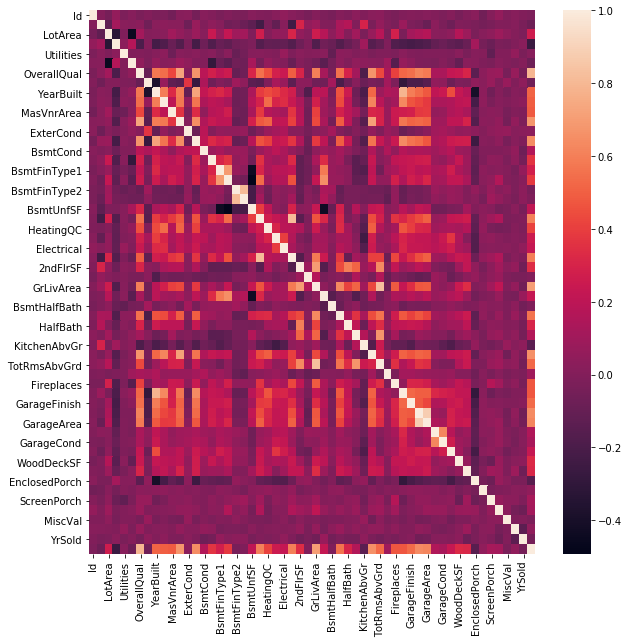

<Figure size 720x720 with 0 Axes>

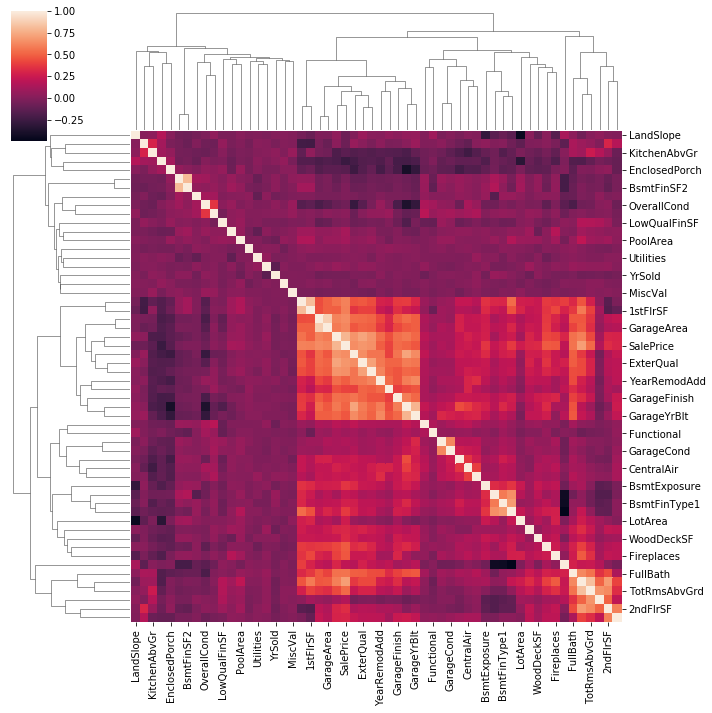

In [183]:
corr = train.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [184]:
display(corr['SalePrice'].sort_values())

LotShape        -0.259696
EnclosedPorch   -0.153601
KitchenAbvGr    -0.141268
LandSlope       -0.076405
MSSubClass      -0.075183
OverallCond     -0.064432
YrSold          -0.042070
BsmtFinType2    -0.036693
MiscVal         -0.022529
Id              -0.019061
BsmtHalfBath    -0.013518
BsmtFinSF2      -0.009805
LowQualFinSF    -0.006371
Utilities        0.015724
ExterCond        0.027286
MoSold           0.044304
3SsnPorch        0.044817
Functional       0.097955
PoolArea         0.109807
ScreenPorch      0.120698
GarageCond       0.130281
GarageQual       0.158249
BsmtCond         0.161287
BedroomAbvGr     0.164934
BsmtUnfSF        0.207366
Electrical       0.227165
BsmtFullBath     0.227829
PavedDrive       0.232936
CentralAir       0.257250
LotArea          0.263540
BsmtFinType1     0.282511
HalfBath         0.304562
OpenPorchSF      0.312711
WoodDeckSF       0.326571
2ndFlrSF         0.336748
BsmtExposure     0.369548
BsmtFinSF1       0.387595
HeatingQC        0.411463
GarageYrBlt 

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [185]:
corr_sp = corr['SalePrice']

print('')
columns_to_drop = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop)

train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterCond', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Functional', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

Now, we need to do some feature scaling!! Normalize this stuff.

For this, and later steps, we'll need to split out our X and y values.

We'll need to reverse transform our predictions before the end, so let's not forget that.

In [186]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

Ok, now we can scale the data. As always, only fit the the scaler on the TRAIN data, to prevent leakage.

Also, we have to do some reshaping to scale the y values.

Ok, having some trouble with scaling the data. Can't scale the y values for some reason.

I'll work on that later.

## Scaling the Data

Most ML models learn much better from data that is similarly scaled. So I will use a normal scaler to, well, normalize the data ranges.

In [187]:
# Also, scale the data!!
# Here, we're only scaling the domain, not the range. Should investigate whether it's worth it to scale the range as well


scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid),columns = X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [188]:
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_scaler.fit(X_train)
# y_scaler.fit(y_train.reshape(-1, 1))

# X_train = X_scaler.transform(X_train)
# X_valid = X_scaler.transform(X_valid)
# X_test = X_scaler.transform(X_test)

# y_train = np.squeeze(y_scaler.transform(y_train.reshape(-1, 1)))
# y_valid = np.squeeze(y_scaler.transform(y_valid.reshape(-1, 1)))

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Decision Tree

'RMSE for Decision Tree Model is $36172.029175851196'

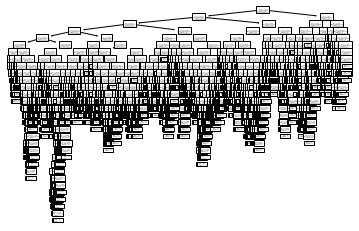

<Figure size 720x720 with 0 Axes>

In [189]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Decision Tree Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_decisiontree.csv',index=False, header =1)

plt.figure(figsize = (10,10))
plot_tree(model)
plt.show()

Well, I guess this isn't the worst, but given that the average sale price is 181286.518836, we're looking at about 20% error on average.

Ok, let's upload to Kaggle and compare:

Decision Tree Model got a score of 0.23263, which is substantially worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

Look at that decision tree. Clearly we're substantially overfitting the training data. The methods below will help with that.

## Random Forest

Everyone knows random forest is way better than simple decision tree!!! Let's put that to the test.

In [190]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Random Forest Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_randomforest.csv',index=False, header =1)



'RMSE for Random Forest Model is $26636.626372148734'

Alright, so far we're definitely beating Decision Tree. Let's also sumbit to Kaggle to see how we're doing.

model2 got a score of 0.16133, which is a SUBSTANTIAL improvement over the decision tree. However, it's still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.


## XGBoost

XGBoost was the hottest model a few years ago. However, it's said to have been surpased by LightGBM these days. Let's find out!!!

[18:48:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



'RMSE for XGBoost Model is $25004.079944467027'

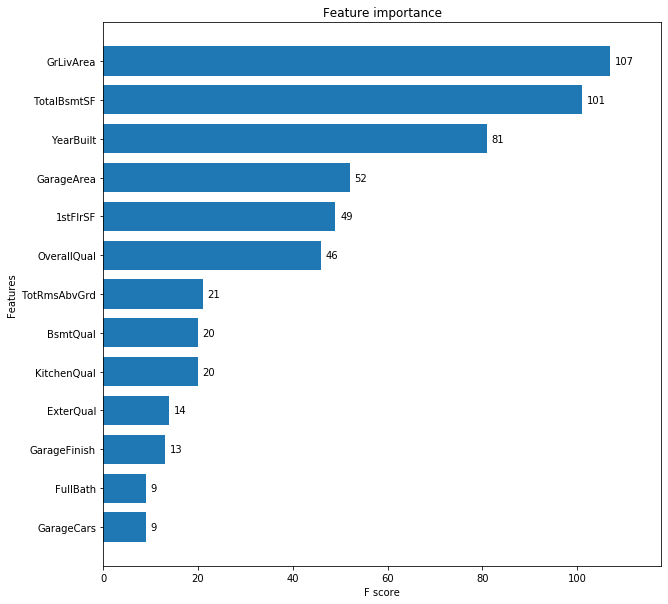

In [191]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for XGBoost Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_xgb.csv',index=False, header =1)

plt.rcParams["figure.figsize"] = (10, 10)
xgb.plot_importance(model, height = .75, grid = False)
plt.show()

## LightGBM

Let's test the new hotness.

'RMSE for LightGBM Model is $24771.59230643214'

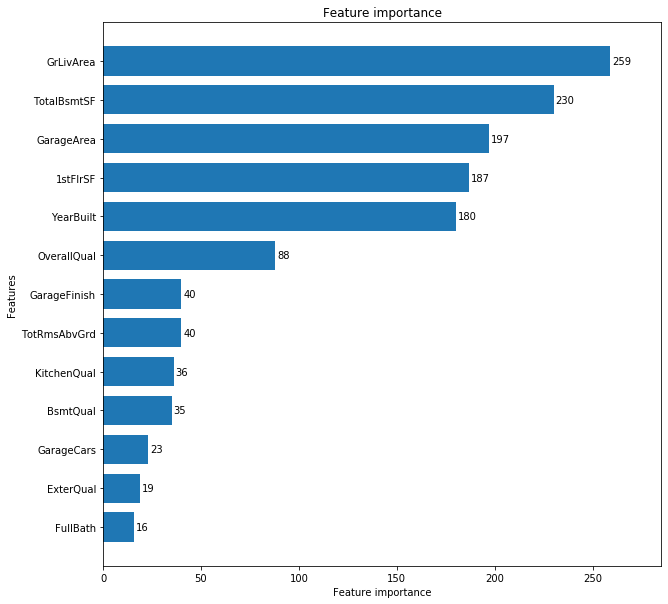

In [192]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgb.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

Yay, even better than decision tree, random forest, or even XGBoost!! Let's also sumbit to Kaggle to see how we're doing.

model4 got a score of 0.16308, which is slightly worse than decision tree. It's also still a bit worse than our current best of 0.13284  

Our best came from XGBoost and the same procedure as the Kaggle tutorials, plus lots of hyperparameter tuning.

We could likely improve with some hyperparameter tuning, but there are some other big picture improvements we could work on, like:

1.  k-fold validation
2.  Better feature generation and selection
3.  Then maybe some hyperparameter tuning

# LightGBM Big Dump

We've done about all we can with my first preprocessing attempt. Let's see how LightGBM does with minimal preprocessing. Just let it decide what to do. I'm going to call this model the "Big Dump" model, because we're basically just dumping everything into LightGBM and letting it figure out the answer.

In [193]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train, valid = train_test_split(housing, test_size = .2)

In [194]:
# Ok, ordinal encoder doesn't work with NaN values. Crap. Let's do the missing value thing from above first

# Drop heavily empty columns
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)


# Also, drop the IDs
train.drop('Id', inplace = True, axis = 1)
valid.drop('Id', inplace = True, axis = 1)
test.drop('Id', inplace = True, axis = 1)


# Impute the rest

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

In [195]:
# LightGBM says it can handle categorical features without the need for integer or one-hot, but it wasn't doing it for me. Piece of trash.
# LightGBM is supposed to do well with integer encoding, so let's try that
# Was having trouble, so I encoded each seperately, when I really should only encode based on the train data

code = OrdinalEncoder()

train.loc[:, cat_columns] = code.fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = code.fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = code.fit_transform(test.loc[:, cat_columns])

Ok, now let's try 

In [196]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

In [197]:
# Also, scale the data!!
# Here, we're only scaling the domain, not the range. Should investigate whether it's worth it to scale the range as well


scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid),columns = X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [198]:
display(X_train)
display(X_valid)
display(X_test)

MSSubClass  MSZoning    LotArea     Street  LotShape  LandContour  \
0      -0.159807  1.533566  -0.466022   0.071858 -1.395944    -4.119060   
1      -0.881874 -0.039046   0.468372   0.071858 -1.395944     0.304227   
2       0.562260 -0.039046  -0.059184   0.071858 -1.395944     0.304227   
3       0.080882 -0.039046  -0.100885   0.071858  0.741900     0.304227   
4       0.080882 -0.039046  -0.130831   0.071858 -1.395944     0.304227   
...          ...       ...        ...        ...       ...          ...   
1163    3.209839 -0.039046  14.374016 -13.916417 -1.395944    -2.644631   
1164   -0.881874 -0.039046   0.004347   0.071858  0.741900     0.304227   
1165    2.487772 -0.039046  -0.775559   0.071858  0.741900     0.304227   
1166   -0.881874 -0.039046  -0.209194   0.071858 -1.395944     0.304227   
1167    0.321571  1.533566  -0.389897   0.071858  0.741900     0.304227   

      Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0     -0.029273   0.608965  -0.222166      0.777140  ...     0.774472   
1     -0.029273   0.608965  -0.222166     -1.069143  ...     0.109748   
2     -0.029273  -1.233707  -0.222166     -0.229923  ...    -0.298151   
3     -0.029273  -1.847931  -0.222166     -0.062079  ...     0.079534   
4     -0.029273   0.608965  -0.222166     -1.236987  ...     0.623399   
...         ...        ...        ...           ...  ...          ...   
1163  -0.029273  -1.847931   6.887142      1.784204  ...    -0.706050   
1164  -0.029273   0.608965  -0.222166     -0.062079  ...    -0.706050   
1165  -0.029273   0.608965  -0.222166      0.609296  ...    -0.298151   
1166  -0.029273   0.608965  -0.222166     -0.062079  ...    -0.706050   
1167  -0.029273  -1.847931  -0.222166     -0.565611  ...    -0.706050   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    MoSold  \
0         -0.359799  -0.117386    -0.274629 -0.064648 -0.087072  0.982488   
1         -0.359799  -0.117386     2.602442 -0.064648 -0.087072 -1.222918   
2         -0.359799  -0.117386    -0.274629 -0.064648 -0.087072 -0.120215   
3         -0.359799  -0.117386    -0.274629 -0.064648 -0.087072 -0.120215   
4         -0.359799  -0.117386    -0.274629 -0.064648 -0.087072 -0.120215   
...             ...        ...          ...       ...       ...       ...   
1163      -0.359799  -0.117386    -0.274629 -0.064648  1.184549  0.614921   
1164      -0.359799  -0.117386     2.870492 -0.064648 -0.087072 -0.855350   
1165      -0.359799  -0.117386    -0.274629 -0.064648 -0.087072  0.247353   
1166      -0.359799  -0.117386    -0.274629 -0.064648  2.092849  0.247353   
1167       1.862090  -0.117386    -0.274629 -0.064648 -0.087072  0.247353   

        YrSold  SaleType  SaleCondition  
0     0.152852 -3.019635      -3.419582  
1     1.672267  0.309545       0.210567  
2     0.912560  0.309545       0.210567  
3    -0.606855  0.309545       0.210567  
4     0.152852  0.309545      -3.419582  
...        ...       ...            ...  
1163  0.152852  0.309545       0.210567  
1164 -0.606855  0.309545       0.210567  
1165  0.912560  0.309545       0.210567  
1166 -0.606855  0.309545       0.210567  
1167  0.912560  0.309545       0.210567  

[1168 rows x 73 columns]

MSSubClass  MSZoning   LotArea     Street  LotShape  LandContour  \
0     -0.881874 -0.039046  0.189714 -13.916417  0.741900     0.304227   
1     -0.159807 -0.039046  0.329650 -13.916417 -1.395944     0.304227   
2     -0.881874 -0.039046  0.333568 -13.916417 -1.395944    -2.644631   
3     -0.881874 -0.039046 -0.203504 -13.916417  0.741900     0.304227   
4     -0.881874 -0.039046 -0.119543 -13.916417  0.741900     0.304227   
..          ...       ...       ...        ...       ...          ...   
287    0.080882  1.533566 -0.672007 -13.916417  0.741900    -2.644631   
288   -0.881874 -0.039046  0.175628 -13.916417 -0.683329    -1.170202   
289   -0.159807  1.533566  0.165739 -13.916417 -1.395944     0.304227   
290   -0.159807 -4.756883 -0.196973 -13.916417 -1.395944     0.304227   
291    1.525016 -0.039046 -0.350902 -13.916417 -1.395944     0.304227   

     Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0    -0.029273  -1.847931  -0.222166     -0.901299  ...    -0.267936   
1    -0.029273   0.608965  -0.222166     -0.229923  ...    -0.252829   
2    -0.029273  -1.847931  -0.222166      1.448516  ...     0.064426   
3    -0.029273   0.608965  -0.222166     -1.236987  ...    -0.177292   
4    -0.029273   0.608965  -0.222166     -0.062079  ...    -0.706050   
..         ...        ...        ...           ...  ...          ...   
287  -0.029273   0.608965  -0.222166      0.609296  ...    -0.706050   
288  -0.029273  -1.847931   3.332488     -1.236987  ...    -0.706050   
289  -0.029273   0.608965  -0.222166      0.609296  ...    -0.706050   
290  -0.029273  -1.847931  -0.222166     -0.565611  ...    -0.706050   
291  -0.029273  -1.847931  -0.222166      1.448516  ...     0.109748   

     EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    MoSold  \
0         0.272710  -0.117386    -0.274629 -0.064648 -0.087072 -0.120215   
1        -0.359799  10.562804    -0.274629 -0.064648  1.184549  1.350056   
2        -0.359799  -0.117386    -0.274629 -0.064648 -0.087072  0.247353   
3        -0.359799   4.688699    -0.274629 -0.064648 -0.087072 -0.487782   
4        -0.359799  -0.117386     2.280782 -0.064648 -0.087072 -0.855350   
..             ...        ...          ...       ...       ...       ...   
287       1.683690  -0.117386    -0.274629 -0.064648 -0.087072  0.982488   
288      -0.359799  -0.117386    -0.274629 -0.064648 -0.087072  1.717624   
289      -0.359799  -0.117386    -0.274629 -0.064648 -0.087072 -0.487782   
290       2.170235  -0.117386    -0.274629 -0.064648 -0.087072  1.350056   
291      -0.359799  -0.117386     2.227172 -0.064648 -0.087072 -0.120215   

       YrSold  SaleType  SaleCondition  
0   -0.606855 -1.687963       0.210567  
1    0.912560 -1.687963       0.210567  
2   -0.606855 -1.687963       0.210567  
3    1.672267 -1.687963       0.210567  
4    1.672267 -1.687963       0.210567  
..        ...       ...            ...  
287  0.912560 -1.687963       0.210567  
288  0.912560 -1.687963       0.210567  
289 -0.606855 -1.687963       0.210567  
290  0.912560 -4.351307      -3.419582  
291  1.672267 -1.687963       0.210567  

[292 rows x 73 columns]

MSSubClass  MSZoning   LotArea    Street  LotShape  LandContour  \
0      -0.881874 -1.611658  0.097077  0.071858  0.741900     0.304227   
1      -0.881874 -0.039046  0.343830  0.071858 -1.395944     0.304227   
2       0.080882 -0.039046  0.303062  0.071858 -1.395944     0.304227   
3       0.080882 -0.039046 -0.056292  0.071858 -1.395944     0.304227   
4       1.525016 -0.039046 -0.520224  0.071858 -1.395944    -2.644631   
...          ...       ...       ...       ...       ...          ...   
1454    2.487772  1.533566 -0.806531  0.071858  0.741900     0.304227   
1455    2.487772  1.533566 -0.810449  0.071858  0.741900     0.304227   
1456   -0.881874 -0.039046  0.878662  0.071858  0.741900     0.304227   
1457    0.682605 -0.039046 -0.013098  0.071858  0.741900     0.304227   
1458    0.080882 -0.039046 -0.089037  0.071858  0.741900     0.304227   

      Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0     -0.029273   0.608965  -0.222166     -0.062079  ...    -0.706050   
1     -0.029273  -1.847931  -0.222166     -0.062079  ...    -0.162184   
2     -0.029273   0.608965  -0.222166     -0.733455  ...    -0.192399   
3     -0.029273   0.608965  -0.222166     -0.733455  ...    -0.162184   
4     -0.029273   0.608965  -0.222166      1.616360  ...     0.532755   
...         ...        ...        ...           ...  ...          ...   
1454  -0.029273   0.608965  -0.222166     -0.397767  ...    -0.706050   
1455  -0.029273   0.608965  -0.222166     -0.397767  ...    -0.343473   
1456  -0.029273   0.608965  -0.222166     -0.229923  ...    -0.706050   
1457  -0.029273   0.608965  -0.222166     -0.229923  ...    -0.222614   
1458  -0.029273   0.608965   3.332488     -0.229923  ...     0.019104   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea    MiscVal    MoSold  \
0         -0.359799  -0.117386     1.869772 -0.064648  -0.087072 -0.120215   
1         -0.359799  -0.117386    -0.274629 -0.064648  22.620446 -0.120215   
2         -0.359799  -0.117386    -0.274629 -0.064648  -0.087072 -1.222918   
3         -0.359799  -0.117386    -0.274629 -0.064648  -0.087072 -0.120215   
4         -0.359799  -0.117386     2.298652 -0.064648  -0.087072 -1.958053   
...             ...        ...          ...       ...        ...       ...   
1454      -0.359799  -0.117386    -0.274629 -0.064648  -0.087072 -0.120215   
1455      -0.359799  -0.117386    -0.274629 -0.064648  -0.087072 -0.855350   
1456      -0.359799  -0.117386    -0.274629 -0.064648  -0.087072  0.982488   
1457      -0.359799  -0.117386    -0.274629 -0.064648   1.184549  0.247353   
1458      -0.359799  -0.117386    -0.274629 -0.064648  -0.087072  1.717624   

        YrSold  SaleType  SaleCondition  
0     1.672267  0.309545       0.210567  
1     1.672267  0.309545       0.210567  
2     1.672267  0.309545       0.210567  
3     1.672267  0.309545       0.210567  
4     1.672267  0.309545       0.210567  
...        ...       ...            ...  
1454 -1.366563  0.309545       0.210567  
1455 -1.366563  0.309545      -3.419582  
1456 -1.366563  0.309545      -3.419582  
1457 -1.366563  0.309545       0.210567  
1458 -1.366563  0.309545       0.210567  

[1459 rows x 73 columns]

In [199]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Big Dump LightGBM is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdump.csv',index=False, header =1)

'RMSE for Big Dump LightGBM is $36313.77256105369'

Well, I've run this a few times, and it keeps changing. Let's kaggle it and see how we do.

Kaggle: .14081
    
Well crap, this is better than even my attempt with all the encoding and stuff. What a waste of time! Still, that's probably because I dropped those other categorical columns.

Let's try tuning this bad boy.

## Grid Search the Big Dump Model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    4.6s finished


Best score reached: -767998136.9089749 with params: {'learning_rate': 0.1, 'num_leaves': 50} 



"RMSE for LightGBM Big Dump Grid Search with parameters {'learning_rate': 0.1, 'num_leaves': 50} is $36360.81500932315"

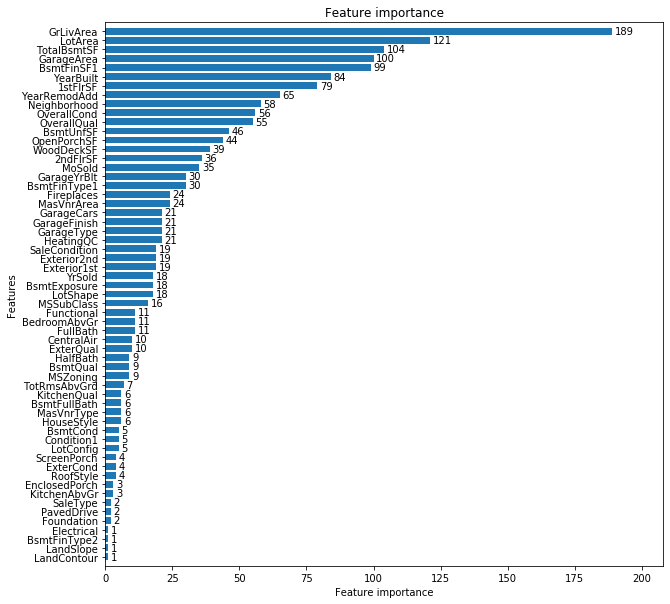

In [200]:
param_test = {'num_leaves': range(50, 60), 
             'learning_rate': [.1],
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=3, n_estimators=5000, verbose = -1)



gs = GridSearchCV(
            estimator=model, 
            param_grid=param_test, 
            scoring='neg_root_mean_squared_error',
            #cv=5,
            refit=True,
            verbose=True,
            n_jobs = 3
            )

gs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False, early_stopping_rounds = 30)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

model = lgb.LGBMRegressor(**gs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Big Dump Grid Search with parameters {gs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdumpgs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

Ok, this did eventually give us a decent result, but it's SLOW AS HECK to grid search, and I'm getting bored. Let's RANDOM SEARCH BABY!!!

## Random Search the Big Dump Model

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   19.5s
[Parallel(n_jobs=3)]: Done 537 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 887 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 1427 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 1977 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 2777 tasks      | elapsed:  5.2min
[Parallel(n_jobs=3)]: Done 3638 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 4554 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 4995 out of 5000 | elapsed:  8.9min remaining:    0.4s
[Parallel(n_jobs=3)]: Done 5000 out of 5000 | elapsed:  8.9min finished


Best score reached: -692367248.2188838 with params: {'num_leaves': 5, 'learning_rate': 0.05, 'early_stopping_rounds': 150} 



"RMSE for LightGBM Big Dump Random Search with parameters {'num_leaves': 5, 'learning_rate': 0.05, 'early_stopping_rounds': 150} is $39204.255995484426"

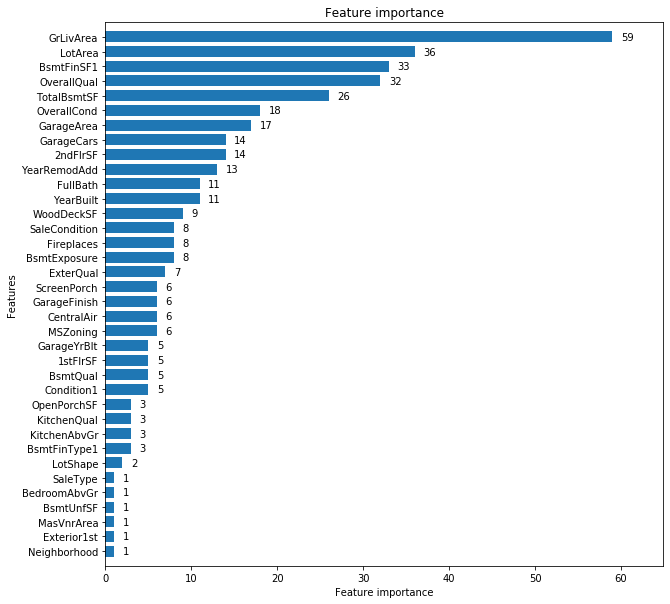

In [201]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'early_stopping_rounds' : range(10, 200, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=3, n_estimators=5000, verbose = -1)



rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 1000,
            n_jobs = 3
            )

rs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')



model = lgb.LGBMRegressor(**rs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Big Dump Random Search with parameters {rs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdumprs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. "RMSE for model9 with parameters {'num_leaves': 10, 'learning_rate': 0.02, 'early_stopping_rounds': 180} is 36890.537657012734"
2. "RMSE for model9 with parameters {'num_leaves': 11, 'learning_rate': 0.01, 'early_stopping_rounds': 30} is 47800.831296522185"
3. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.02, 'early_stopping_rounds': 30} is 38031.55374833302"
4. "RMSE for model9 with parameters {'num_leaves': 8, 'learning_rate': 0.2, 'early_stopping_rounds': 10} is 28506.639199674595"
5. "RMSE for model9 with parameters {'num_leaves': 14, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28387.987302916474"
6. "RMSE for model9 with parameters {'num_leaves': 15, 'learning_rate': 0.1, 'early_stopping_rounds': 10} is 28320.97315991774
7. "RMSE for model9 with parameters {'num_leaves': 3, 'learning_rate': 0.06, 'early_stopping_rounds': 40} is 36486.701188774045"


List of things that performed decently:  

1. learning_rate = .1, num_leaves = 9, early_stopping_rounds = 30, RMSE for model8 is 19088.782686261766'
2. {'early_stopping_rounds': 100, 'learning_rate': 0.01, 'num_leaves': 11}, 'RMSE for model8 is 19088.782686261766'
3. {'learning_rate': 0.01, 'num_leaves': 6, early_stopping rounds = 50}, 'RMSE for model8 is 36324.154902046415'










2. Kaggle: .14039
A little better, still not beating our og. Let's go nuts with hyper tuning.

3. 

1. Kaggle:

# Reprocessing the Data 1

Let's try some other ways of preprocessing the data.

For my first attempt, I'll keep everything but very empty columns, use my encoding where possible, otherwise use integer encoding.

Also, no more validation split. Use CV

## Data Reprocessing 1

In [202]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

columns_to_drop = housing.columns[housing.isnull().sum() > len(housing) * .15]
housing.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

num_columns = housing.select_dtypes(exclude=['object']).columns
cat_columns = housing.select_dtypes(include=['object']).columns

# Impute Categorical Values
housing.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(housing.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
housing.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(housing.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    housing[ordinal_features[i]] = housing[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

cat_columns = housing.select_dtypes(include=['object']).columns

code = OrdinalEncoder()

housing.loc[:, cat_columns] = code.fit_transform(housing.loc[:, cat_columns])
test.loc[:, cat_columns] = code.fit_transform(test.loc[:, cat_columns])

X_train = housing.iloc[:, :-1]
y_train = housing.iloc[:, -1]

X_test = test

# Also, scale the data!!
# Here, we're only scaling the domain, not the range. Should investigate whether it's worth it to scale the range as well

scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

## Random Search Preprocessing 1

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   43.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  6.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 10.8min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 15.2min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed: 21.6min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed: 29.3min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed: 37.4min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed: 46.6min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed: 57.3min
[Parallel(n_jobs=3)]: Done 5000 out of 5000 | elapsed: 57.4min finished


Best score reached: -748559016.212418 with params: {'num_leaves': 8, 'n_estimators': 1680, 'learning_rate': 0.04} 


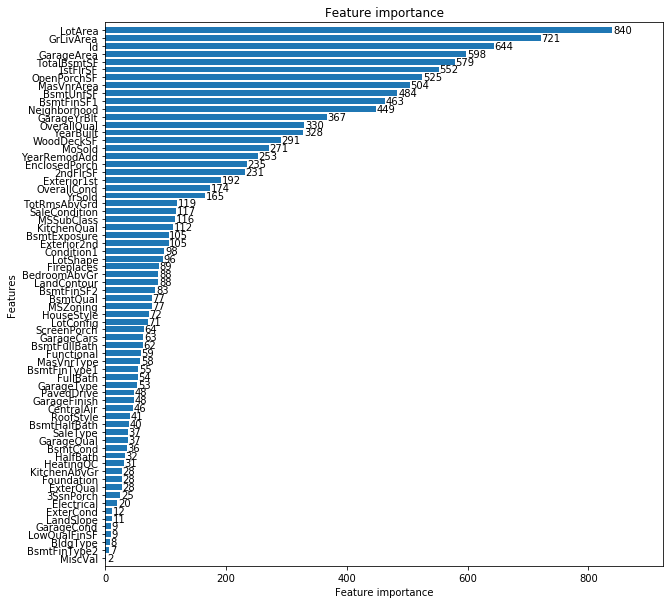

In [203]:
n_iter = 1000

param_test = {
                'num_leaves': range(2, 20), 
                'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
                'n_estimators' : range(100, 5000, 10)
            }


model = lgb.LGBMRegressor(silent=True, n_jobs=3, verbose = -1)


rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = n_iter,
            n_jobs = 3
            )

rs.fit(X_train, y_train, verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMRegressor(**rs.best_params_)

model.fit(X_train, y_train, verbose = False)

predict = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgb1.csv',index=False, header =1)

lgb.plot_importance(model, height = .75, figsize = (10, 10), grid = False)
plt.show()

List of things that performed decently:  

1. "RMSE for model7 with parameters {'num_leaves': 7, 'learning_rate': 0.1, 'early_stopping_rounds': 30} is 26200.168821416515"
2. "RMSE for model7 with parameters {'num_leaves': 12, 'learning_rate': 0.3, 'early_stopping_rounds': 40} is 35874.30209147329"
3. "RMSE for model7 with parameters {'num_leaves': 9, 'learning_rate': 0.02, 'early_stopping_rounds': 40} is 27146.89532722071"
4. "RMSE for model7 with parameters {'num_leaves': 18, 'learning_rate': 0.08, 'early_stopping_rounds': 40} is 24956.638132730524"


5. [Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished  
Best score reached: -28173.823200826864 with params: {'num_leaves': 14, 'learning_rate': 0.06, 'early_stopping_rounds': 40}   
"RMSE for Repreprocessed LightGBM Random Search with parameters {'num_leaves': 14, 'learning_rate': 0.06, 'early_stopping_rounds': 40} is $27616.147114770138"  

5. Kaggle: 15817


# Reprocessing the Data 2

Let's reprocess one more time, with a few changes:
1. No validation set. We'll use the cross validation built into random search to validate our model.
2. One hot encoding for columns that I haven't hand encoded.
3. Train the final model on the whole dataset. Again, no validation split.

## Data Reprocessing 2

In [204]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train = housing

columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map
heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}
kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]
ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

Here's where things get interesting. I think there may be a different number of unique entries for the remaining categorical columns. Which means that when I one-hot, the number of features won't match. Let's check and see.

In [205]:
cat_columns = train.select_dtypes(include=['object']).columns

for feature in cat_columns:    
    difference = set(train[feature].unique()) - set(test[feature].unique())
    if difference != set():
        display(feature)
        display(difference)

'Condition2'

{'RRAe', 'RRAn', 'RRNn'}

'HouseStyle'

{'2.5Fin'}

'RoofMatl'

{'ClyTile', 'Membran', 'Metal', 'Roll'}

'Exterior1st'

{'ImStucc', 'Stone'}

'Exterior2nd'

{'Other'}

'Heating'

{'Floor', 'OthW'}

Aha! We've found the culprits! Let's count up how many of each type appear in both train and test, to help us decide what to do with them.

In [206]:
for feature in cat_columns:    
    difference = set(train[feature].unique()) - set(test[feature].unique())
    if difference != set():
        for value in difference:
            diff = len(train[train[feature] == value].index) - len(test[test[feature] == value].index)
            print(f'There are {diff} more of {value} in train than test.')

There are 1 more of RRAe in train than test.
There are 1 more of RRAn in train than test.
There are 2 more of RRNn in train than test.
There are 8 more of 2.5Fin in train than test.
There are 1 more of Roll in train than test.
There are 1 more of Membran in train than test.
There are 1 more of Metal in train than test.
There are 1 more of ClyTile in train than test.
There are 1 more of ImStucc in train than test.
There are 2 more of Stone in train than test.
There are 1 more of Other in train than test.
There are 1 more of Floor in train than test.
There are 2 more of OthW in train than test.


As I suspected, all of the additional values occur in the train set, which makes sense, as that is a much larger set than the test set. So, after we one hot, let's manually add in the missing values above as columns of zeroes.

In [207]:
train = pd.get_dummies(train, columns=cat_columns)
test = pd.get_dummies(test, columns=cat_columns)

In [208]:
display(train)
display(test)

Id  MSSubClass  LotArea  LotShape  Utilities  LandSlope  \
0        1.0        60.0   8450.0       3.0          3          2   
1        2.0        20.0   9600.0       3.0          3          2   
2        3.0        60.0  11250.0       2.0          3          2   
3        4.0        70.0   9550.0       2.0          3          2   
4        5.0        60.0  14260.0       2.0          3          2   
...      ...         ...      ...       ...        ...        ...   
1455  1456.0        60.0   7917.0       3.0          3          2   
1456  1457.0        20.0  13175.0       3.0          3          2   
1457  1458.0        70.0   9042.0       3.0          3          2   
1458  1459.0        20.0   9717.0       3.0          3          2   
1459  1460.0        20.0   9937.0       3.0          3          2   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd  ...  SaleType_ConLw  \
0             7.0          5.0     2003.0        2003.0  ...               0   
1             6.0          8.0     1976.0        1976.0  ...               0   
2             7.0          5.0     2001.0        2002.0  ...               0   
3             7.0          5.0     1915.0        1970.0  ...               0   
4             8.0          5.0     2000.0        2000.0  ...               0   
...           ...          ...        ...           ...  ...             ...   
1455          6.0          5.0     1999.0        2000.0  ...               0   
1456          6.0          6.0     1978.0        1988.0  ...               0   
1457          7.0          9.0     1941.0        2006.0  ...               0   
1458          5.0          6.0     1950.0        1996.0  ...               0   
1459          5.0          6.0     1965.0        1965.0  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1455             0             0            1                      0   
1456             0             0            1                      0   
1457             0             0            1                      0   
1458             0             0            1                      0   
1459             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   
1459                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...                    ...  
1455                     1                      0  
1456                     1            

Id  MSSubClass  LotArea  LotShape  Utilities  LandSlope  \
0     1461.0        20.0  11622.0       3.0          3          2   
1     1462.0        20.0  14267.0       2.0          3          2   
2     1463.0        60.0  13830.0       2.0          3          2   
3     1464.0        60.0   9978.0       2.0          3          2   
4     1465.0       120.0   5005.0       2.0          3          2   
...      ...         ...      ...       ...        ...        ...   
1454  2915.0       160.0   1936.0       3.0          3          2   
1455  2916.0       160.0   1894.0       3.0          3          2   
1456  2917.0        20.0  20000.0       3.0          3          2   
1457  2918.0        85.0  10441.0       3.0          3          2   
1458  2919.0        60.0   9627.0       3.0          3          1   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd  ...  SaleType_ConLw  \
0             5.0          6.0     1961.0        1961.0  ...               0   
1             6.0          6.0     1958.0        1958.0  ...               0   
2             5.0          5.0     1997.0        1998.0  ...               0   
3             6.0          6.0     1998.0        1998.0  ...               0   
4             8.0          5.0     1992.0        1992.0  ...               0   
...           ...          ...        ...           ...  ...             ...   
1454          4.0          7.0     1970.0        1970.0  ...               0   
1455          4.0          5.0     1970.0        1970.0  ...               0   
1456          5.0          7.0     1960.0        1996.0  ...               0   
1457          5.0          5.0     1992.0        1992.0  ...               0   
1458          7.0          5.0     1993.0        1994.0  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1454             0             0            1                      0   
1455             0             0            1                      1   
1456             0             0            1                      1   
1457             0             0            1                      0   
1458             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1454                      0                     0                     0   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        1                      0  
4                        1                      0  
...                    ...                    ...  
1454                     1                      0  
1455                     0            

In [209]:
for feature in cat_columns:    
    difference = set(train[feature].unique()) - set(test[feature].unique())
    if difference != set():
        for value in 

SyntaxError: invalid syntax (<ipython-input-209-8d7837d4d8c4>, line 4)

In [ ]:
display(train)

In [ ]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, verbose = False)

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgb2.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

## Random Search Preprocessing 2

In [ ]:
param_test = {'num_leaves': range(2, 20), 
             'learning_rate': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1],
              'early_stopping_rounds' : range(10, 50, 10)
#              'min_child_samples': range(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': (.2, .3, .4, .5, .6, .7, .8), 
#              'colsample_bytree': (.2, .3, .4, .5, .6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
            }



model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=3, n_estimators=5000, verbose = -1)



rs = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_test, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            refit=True,
            verbose=True,
            n_iter = 10,
            n_jobs = 3
            )

rs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False)

print(f'Best score reached: {rs.best_score_} with params: {rs.best_params_} ')

model = lgb.LGBMRegressor(**rs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Repreprocessed LightGBM Random Search with parameters {rs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_reprelgbrs2.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

1. Kaggle: 

2. 

# Conclusion

Well, we've had a lot of fun, but what have we learned?  
1. 

## Future Research

I'm ready to move on to other research and other datasets, but what would I do if I were to continue with this dataset?  

1. Develop pipelines for all of my procedures. sklearn has some cool built in functions for creating pipelines.
2. Use dimensionality reduction to try to look for the most important features / linear combinations of features.
3. Use L1 / Lasso to select features